**Site 4 is University of California Berkeley**. This is revealed in [this](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-674237) discussion post. They provide energy consumption of their building publicly in https://engagementdashboard.com/ucb/ucb/ . This is mentioned in [this](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/118039#latest-677508) discussion post already.

I captured the data transfer of engagement dashboard via developer tools in Chrome. Front-end interface communicates to backend with basic rest api calls. In this notebook, I scraped the historical energy consumption data of several buildings. Even though the web site shows 1 year data maximum, rest calls return data from 2016.

There are 91 buildings existing in ASHRAE data set already. I've found **81 buildings** highly correlated to UC Berkeley data set.

**There are many ways to support a study - starring it is one.**


In [1]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',100)

## Buildings

There are 123 buildings listed in the Engagement Dashboard of UC Berkeley. They have id numbers from 173 to 292. Exceptionally, 3727, 5824 and 5992 are in the list.

In [2]:
locations = []
for i in range(173, 292+1):
    locations.append(i)

locations.append(3727)
locations.append(5824)
locations.append(5992)

## Retrieve building meta data

The first service returns the metadata of buildings. The metadata covers name of building, space use (similar to primary use feature in ASHRAE data set), time zone, built year and square feet. 

We will use square feet and built year features to match buildings in Berkeley to ASHRAE data set.

Basically, we will call the following address to get metadata: https://engagementdashboard.com/a/location/metadata?locationIds=?


In [6]:
if True:
    metadata_list = []

    pbar = tqdm(range(0, len(locations)))
    for index in pbar:
        location = locations[index]
        location_metadata = []
        http_address = "http://engagementdashboard.com/a/location/metadata?locationIds=%s" % str(location)
        #print("Calling ",http_address)

        #try max 3 times
        try:
            resp = requests.get(http_address, timeout=120)
        except:
            try:
                resp = requests.get(http_address, timeout=120)
            except:
                resp = requests.get(http_address, timeout=120)

        if resp.status_code == 200:
            resp_json = resp.json()[0]

            #print(resp_json)

            squareFeet = -1; year = -1
            name = ""; spaceUse = ""; address = ""; timezone = ""; resources = ""

            try: squareFeet = resp_json['areaNumber'] 
            except: pass

            try: year = resp_json['yearConstructed']
            except: pass

            try: name = resp_json["name"]
            except: pass

            try: spaceUse = resp_json["spaceUse"]
            except: pass

            try: address = resp_json["address"]
            except: pass

            try: timezone = resp_json["timeZone"]
            except: pass

            try: resources = resp_json["resources"]
            except: pass

            location_metadata.append(location)
            location_metadata.append(squareFeet)
            location_metadata.append(year)
            location_metadata.append(name)
            location_metadata.append(spaceUse)
            location_metadata.append(address)
            location_metadata.append(timezone)
            location_metadata.append(resources)

            metadata_list.append(location_metadata)

100%|██████████| 123/123 [00:30<00:00,  4.06it/s]


In [7]:
source = pd.DataFrame(metadata_list, columns = ['source_id', 'square_feet', 'year', 'name', 'spaceUse', 'address', 'timezone', 'resources'])

In [45]:
source.rename(columns={'building_id':'berkeley_id'}, inplace=True)

In [46]:
source

berkeley_id  square_feet  year  \
0            173       252597  1984   
1            174        43599  1998   
2            175        54000  2015   
3            176       110565  1994   
4            177       111198  1941   
..           ...          ...   ...   
117          291        91594    -1   
118          292        10535  1960   
119         3727        80000  2018   
120         5824       230000  2019   
121         5992         6169    -1   

                                          name           spaceUse  \
0                 Recreational Sports Facility              Other   
1    Silver Space Sciences Laboratory Addition         Laboratory   
2                         Maxwell Family Field  CollegeUniversity   
3                                    Soda Hall         Laboratory   
4                                  Sproul Hall     Administrative   
..                                         ...                ...   
117                   Northwest Parking Garage     VehicleStorage   
118                               Oxford Tract         Laboratory   
119                                  Chou Hall        Unspecified   
120                          Berkeley Way West  CollegeUniversity   
121                     Anna Head Building E&F        Unspecified   

                    address             timezone  \
0    37.868448, -122.262184  America/Los_Angeles   
1    37.880843, -122.243914  America/Los_Angeles   
2      Berkeley, California  America/Los_Angeles   
3    37.875511, -122.258656  America/Los_Angeles   
4    37.869734, -122.258924  America/Los_Angeles   
..                      ...                  ...   
117  37.873696, -122.265848  America/Los_Angeles   
118  37.875274, -122.267085  America/Los_Angeles   
119    Berkeley, California  America/Los_Angeles   
120    Berkeley, California  America/Los_Angeles   
121    berkeley, california  America/Los_Angeles   

                              resources  
0                [Electricity, Outside]  
1                [Electricity, Outside]  
2                [Electricity, Outside]  
3         [Steam, Electricity, Outside]  
4                [Electricity, Outside]  
..                                  ...  
117              [Electricity, Outside]  
118              [Electricity, Outside]  
119  [NaturalGas, Electricity, Outside]  
120              [Electricity, Outside]  
121              [Electricity, Outside]  

[122 rows x 8 columns]

## Building metadata in ASHRAE data set 

In [13]:
target = pd.read_csv("ashrae-energy-prediction/building_metadata.csv")

In [14]:
target.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [15]:
#we believe that UC Berkeley is site id 4. Filter target data frame for just site 4.
target = target[target['site_id'] == 4]

In [16]:
print("There are ",len(target.building_id.unique())," buildings in ASHRAE data set")

There are  91  buildings in ASHRAE data set


In [17]:
ashrae_buildings = target.building_id.unique()

In [20]:
train_df = pd.read_csv("ashrae-energy-prediction/train.csv")
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df = train_df[train_df.building_id.isin(ashrae_buildings)]

In [21]:
train_df.head()

building_id  meter  timestamp  meter_reading
722          565      0 2016-01-01          7.250
723          566      0 2016-01-01          0.519
724          569      0 2016-01-01        246.000
725          570      0 2016-01-01         79.488
726          571      0 2016-01-01         17.000

## Consumption data for found locations

We will call the following service to retrieve consumption data. It basically expects location in Berkeley data set, start time and end time.

My experiments show that the service could return max 6 months data for hourly period. That's why, I will call half periods for years 2016, 2017 and 2018.

https://engagementdashboard.com/a/consumption?endTime=?&granularity=HOUR&locationIds=?&resource=Electricity&startTime=?

Notice that site 4 has just 0 meter type (electricity) in ASHRAE data set. That's why, I passed resource to Electricity.

To speed kernel up, I saved this block's results in the **berkeley_consumptions.csv** file. You can still call retrieveConsumptions functions to get consumption data.

I will call consumption service for both catched buildings and close buildings. That's why, I've written a generic function to call.

In [28]:
def retrieveConsumptions(locations): 
    consumption_list = []
    for index in range(0, len(locations)):
        location = locations[index]
        print(index+1,'/',len(locations), ".",int(location), ".", end='')
        for year in range(2016, 2020):
            print(year, "",end= '')
            for half in range(0, 2):
                if year == 2019 and half == 1: #2019 2nd period is not completed yet (today is 2019-11-23)
                    break
                if half == 0:
                    print("1/2 ", end='')
                    if year == 2019:
                        http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-01-01T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
                    else:
                        http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-06-31T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-01-01T00:00:00.000Z"
                else:
                    print("2/2. ", end='')
                    http_address = "https://engagementdashboard.com/a/consumption?endTime="+str(year)+"-12-31T23:59:59.000Z&granularity=HOUR&locationIds="+str(int(location))+"&resource=Electricity&startTime="+str(year)+"-07-01T00:00:00.000Z"

                #print(http_address)
                
                #try maximum 4 times
                try:
                    resp = requests.get(http_address, timeout=120)
                except:
                    try:
                        resp = requests.get(http_address, timeout=120)
                    except:
                        try:
                            resp = requests.get(http_address, timeout=120)
                        except:
                            resp = requests.get(http_address, timeout=120)
                
                if resp.status_code == 200:
                    resp_json = resp.json()[0]
                    #print(resp_json)
                    consumptions = resp_json["actual"]["data"]
                    #consumptions = resp_json["baseline"]["data"]
                    for i in consumptions:

                        consumption = []

                        value = i["value"]
                        timestamp = i["timestamp"]
                        
                        trx_datetime = datetime.fromtimestamp(timestamp) 
#                         + timedelta(hours=-8) 
                        consumption.append(location)
                        consumption.append(str(trx_datetime))
                        consumption.append(value)
                        
                        consumption_list.append(consumption)
                else:
                    print("Error code ",resp.status_code," returned for building ",location," ",year," ",half)
        print("")    
    return consumption_list

In [29]:

#you can activate this block to retrieve data from the service
consumptions = retrieveConsumptions(locations)
leak = pd.DataFrame(consumptions, columns=['berkeley_id', 'timestamp', 'meter_reading'])
leak['timestamp'] = pd.to_datetime(leak['timestamp'])
leak = leak[leak.timestamp.dt.year >= 2016]

# leak = pd.read_csv("../input/uc-berkeley-consumptions/berkeley_consumptions.csv")
# leak['timestamp'] = pd.to_datetime(leak['timestamp'])

1 / 123 . 173 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
2 / 123 . 174 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
3 / 123 . 175 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
4 / 123 . 176 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
5 / 123 . 177 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
6 / 123 . 178 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
7 / 123 . 179 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
8 / 123 . 180 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
9 / 123 . 181 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
10 / 123 . 182 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
11 / 123 . 183 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
12 / 123 . 184 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
13 / 123 . 185 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
14 / 123 . 186 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2. 2019 1/2 
15 / 123 . 187 .2016 1/2 2/2. 2017 1/2 2/2. 2018 1/2 2/2.

In [30]:
leak.head()

berkeley_id           timestamp  meter_reading
8           173 2016-01-01 00:00:00           68.0
9           173 2016-01-01 01:00:00           68.0
10          173 2016-01-01 02:00:00           68.0
11          173 2016-01-01 03:00:00           68.0
12          173 2016-01-01 04:00:00           68.0

[@stillspeedo](https://www.kaggle.com/stillspeedo) informed me about daylight savings, thank you

In [26]:
# california daylight savings
idx = leak[(( leak['timestamp'] >= "2016-03-13 02:00:00") & (leak['timestamp'] <= "2016-11-06 02:00:00") )
    | ( (leak['timestamp'] >= "2017-03-12 02:00:00") & (leak['timestamp'] <= "2017-11-05 02:00:00") )
    | ( (leak['timestamp'] >= "2018-03-11 02:00:00") & (leak['timestamp'] <= "2018-11-05 02:00:00") ) ].index

#GMT-7 for summer days instead of GMT-8
leak.loc[idx, 'timestamp'] = leak.iloc[idx]['timestamp'] + timedelta(hours=1)

IndexError: positional indexers are out-of-bounds

In [27]:
leak[leak['timestamp'] >= "2016-03-13"].head()

berkeley_id           timestamp  meter_reading
1743          173 2016-03-13 00:00:00          100.0
1744          173 2016-03-13 01:00:00          106.0
1745          173 2016-03-13 02:00:00          106.0
1746          173 2016-03-13 03:00:00           98.0
1747          173 2016-03-13 04:00:00           91.0

In [33]:
berkeley_buildings = list(leak.berkeley_id.unique())

## Analysis

In [34]:
correlation_threshold = 0.79 # we will expect correlation coefficient higher than this value
mae_correlation = 10 #mean absolute error of berkeley and ashrae data should have less than this value

1 . berkeley  176  is highly correlated to ashrae  641  with score  0.9865460290803938
mae:  4.042443162451586  whereas mean:  434.85422943722944  mae / mean:  0.9296087950399264 %


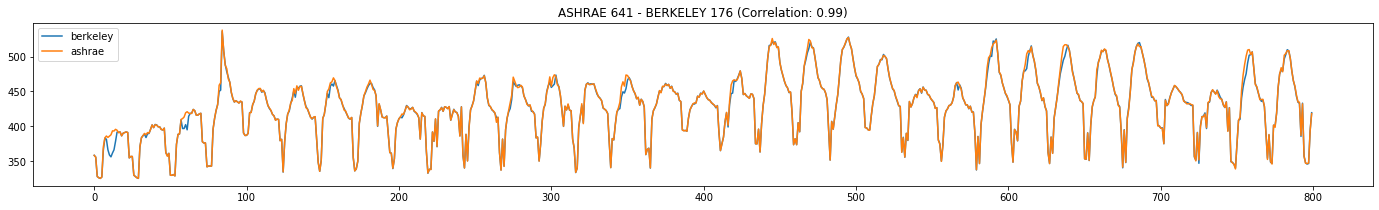

------------------------------------
2 . berkeley  177  is highly correlated to ashrae  643  with score  0.9965628860210552
mae:  1.5797305225409837  whereas mean:  89.9794806010929  mae / mean:  1.7556564140933664 %


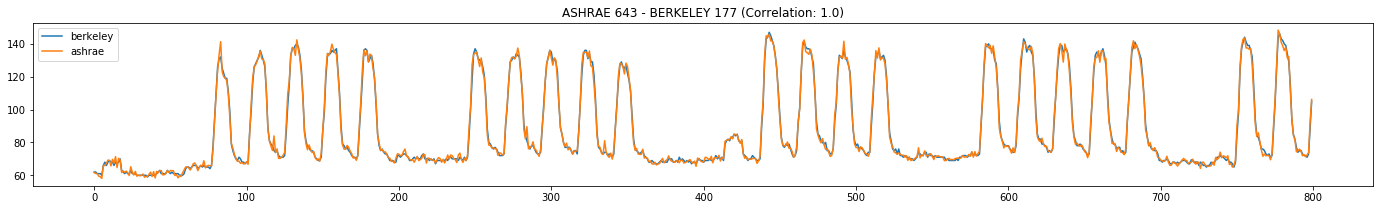

------------------------------------
3 . berkeley  178  is highly correlated to ashrae  646  with score  0.9942787880557409
mae:  1.529303160974499  whereas mean:  42.40566474271402  mae / mean:  3.606365258635069 %


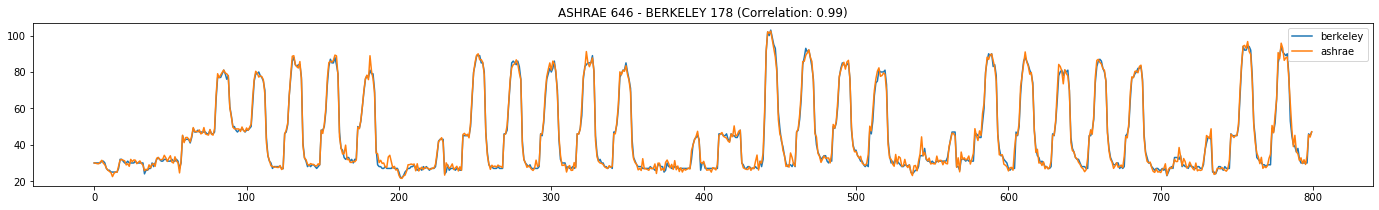

------------------------------------
4 . berkeley  179  is highly correlated to ashrae  621  with score  0.9975383371221892
mae:  0.16953670836054865  whereas mean:  16.58147126061398  mae / mean:  1.022446715951254 %


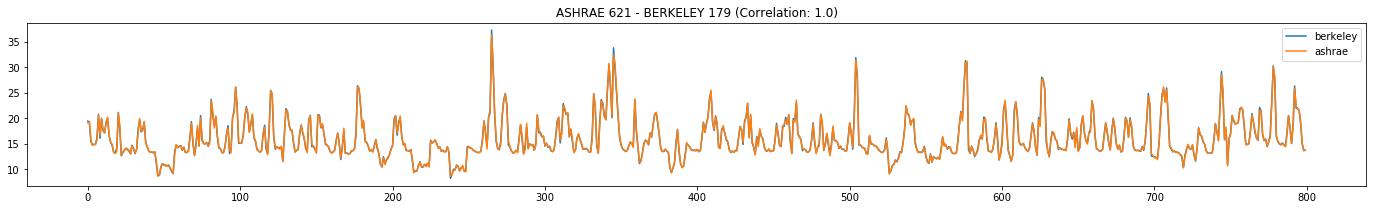

------------------------------------
5 . berkeley  180  is highly correlated to ashrae  649  with score  0.9990767112341732
mae:  1.1917799566236815  whereas mean:  432.6091472450176  mae / mean:  0.27548653656846767 %


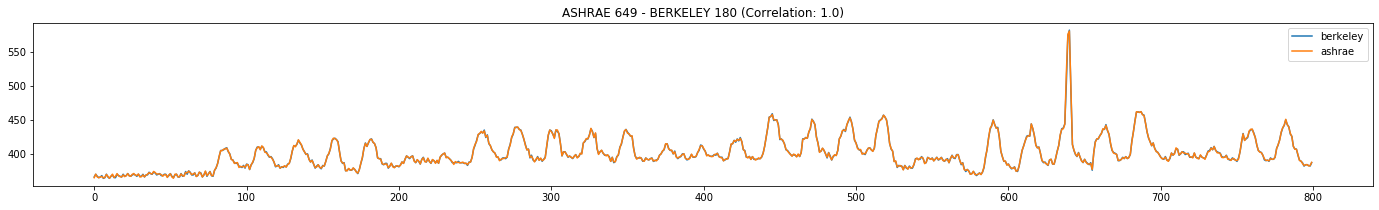

------------------------------------
6 . berkeley  181  is highly correlated to ashrae  650  with score  0.9959576473836776
mae:  5.297390220337053  whereas mean:  117.28009634479618  mae / mean:  4.516870624631016 %


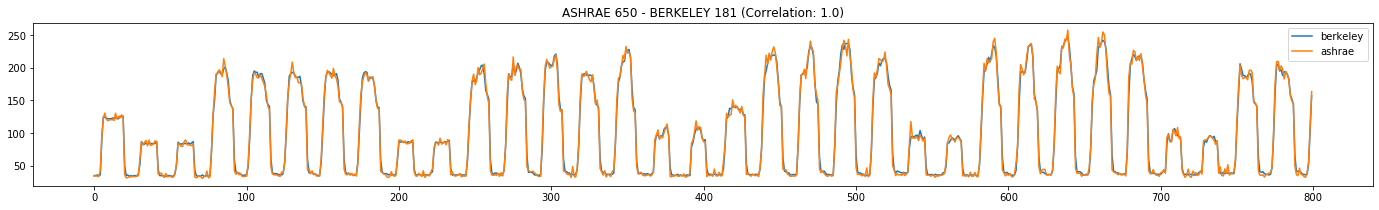

------------------------------------
7 . berkeley  183  is highly correlated to ashrae  652  with score  0.9999323200013364
mae:  0.3881431376638176  whereas mean:  114.21529739031338  mae / mean:  0.3398346338296503 %


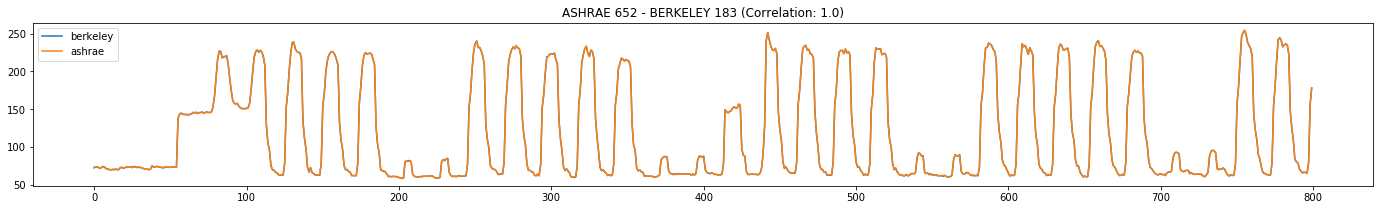

------------------------------------
8 . berkeley  184  is highly correlated to ashrae  653  with score  0.996728145377922
mae:  6.502246444875599  whereas mean:  939.1188110020543  mae / mean:  0.6923774040834728 %


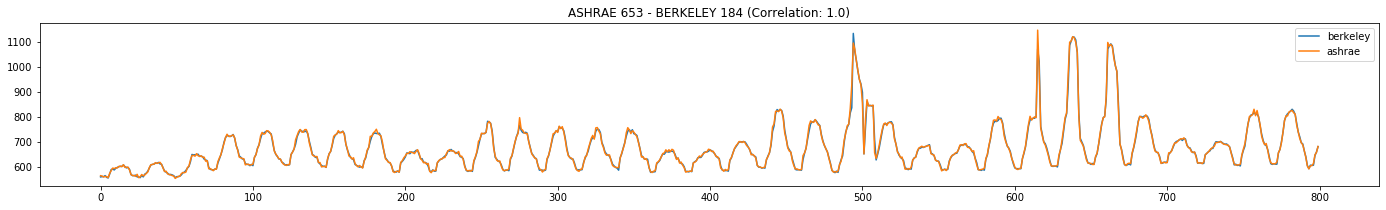

------------------------------------
9 . berkeley  185  is highly correlated to ashrae  654  with score  0.9628456971500806
mae:  0.8250806775449444  whereas mean:  51.17696549868315  mae / mean:  1.6122110201437692 %


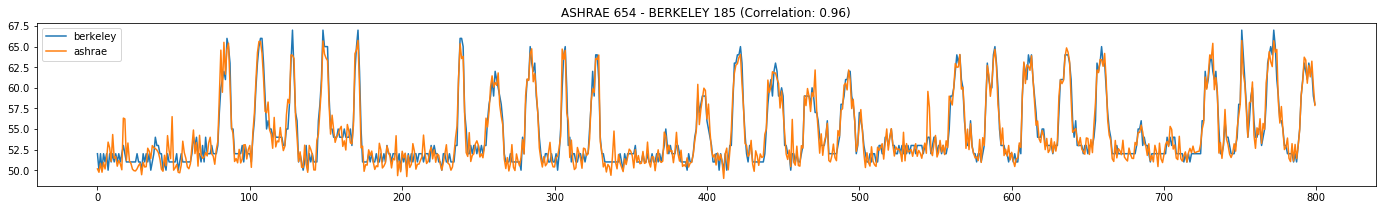

------------------------------------


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


10 . berkeley  188  is highly correlated to ashrae  655  with score  0.9970303129784094
mae:  2.179495765027323  whereas mean:  141.60029233834246  mae / mean:  1.5391887467432581 %


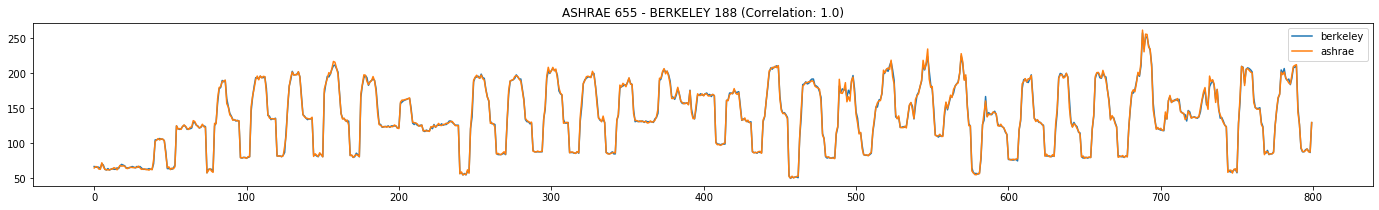

------------------------------------
11 . berkeley  193  is highly correlated to ashrae  623  with score  0.9978955346250947
mae:  0.6224382363387978  whereas mean:  23.85426379781421  mae / mean:  2.609337440109271 %


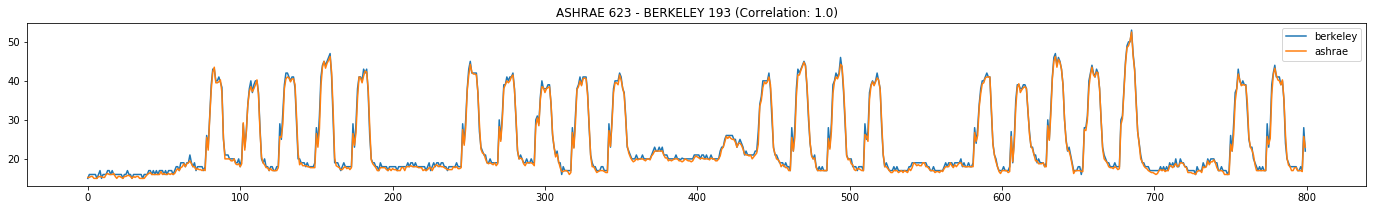

------------------------------------
12 . berkeley  194  is highly correlated to ashrae  576  with score  0.9999998235128693
mae:  0.00017105418943534788  whereas mean:  153.56568567850638  mae / mean:  0.00011138828878311664 %


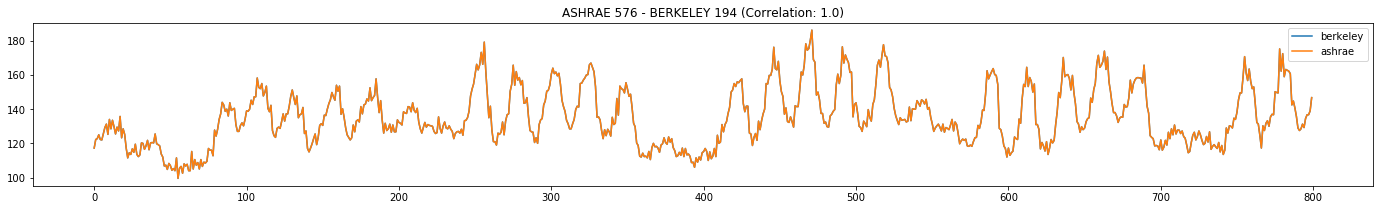

------------------------------------
13 . berkeley  195  is highly correlated to ashrae  642  with score  0.9956053216601715
mae:  0.5983784997153917  whereas mean:  13.438712431693988  mae / mean:  4.452647549062588 %


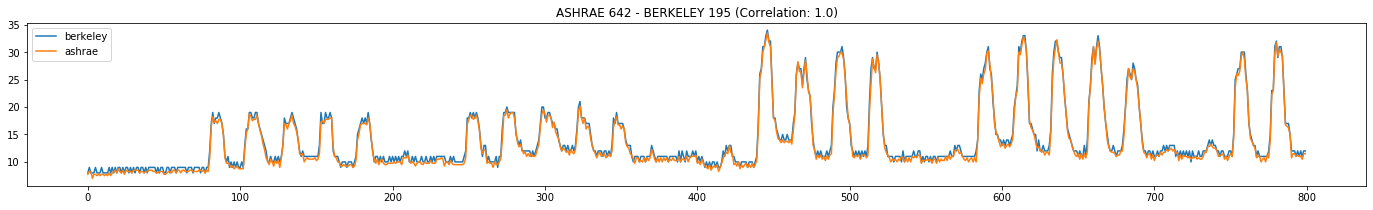

------------------------------------
14 . berkeley  196  is highly correlated to ashrae  582  with score  0.9975753625389747
mae:  0.004788437678837129  whereas mean:  6.398205264965092  mae / mean:  0.07484032600606562 %


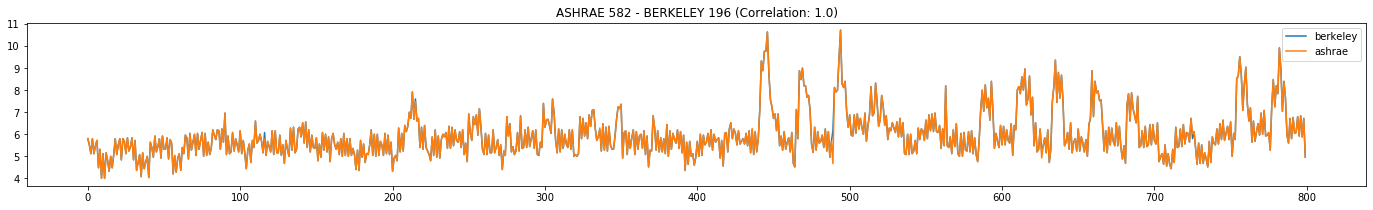

------------------------------------
15 . berkeley  197  is highly correlated to ashrae  636  with score  0.9986573571483747
mae:  0.003469594309488552  whereas mean:  0.1844815582640392  mae / mean:  1.8807269095823094 %


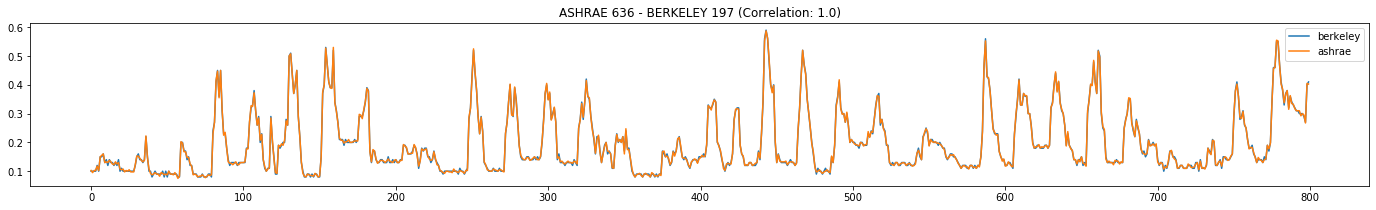

------------------------------------
16 . berkeley  198  is highly correlated to ashrae  637  with score  0.9993610156243301
mae:  0.0034283401279391426  whereas mean:  0.20008313739050257  mae / mean:  1.7134578019176328 %


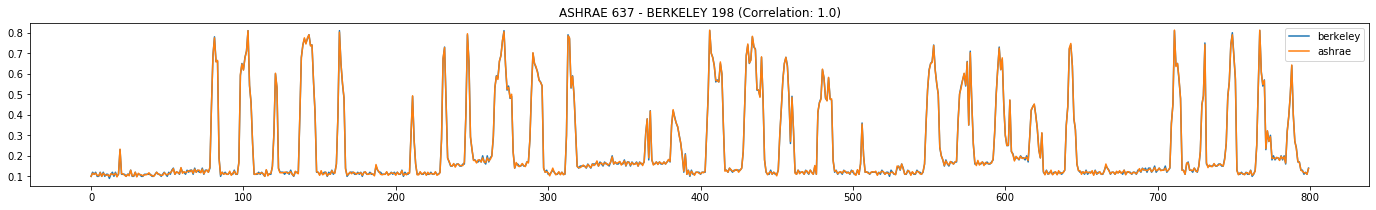

------------------------------------
17 . berkeley  200  is highly correlated to ashrae  639  with score  0.9944107872570385
mae:  0.6754627708561021  whereas mean:  8.356662044626594  mae / mean:  8.08292554190857 %


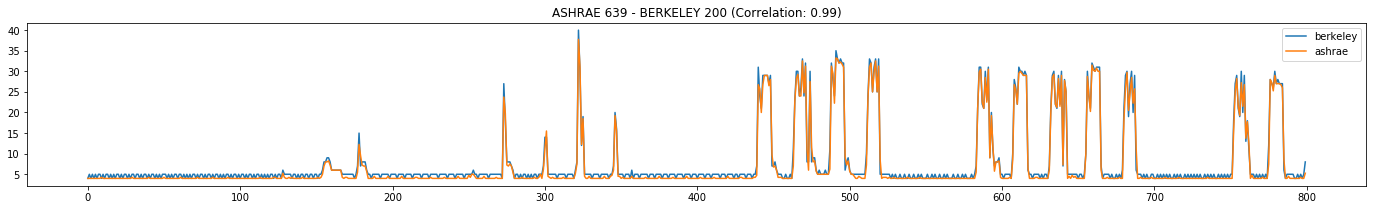

------------------------------------
18 . berkeley  202  is highly correlated to ashrae  591  with score  0.9908143014485574
mae:  1.1416375729621544  whereas mean:  18.945304294032024  mae / mean:  6.0259658818031365 %


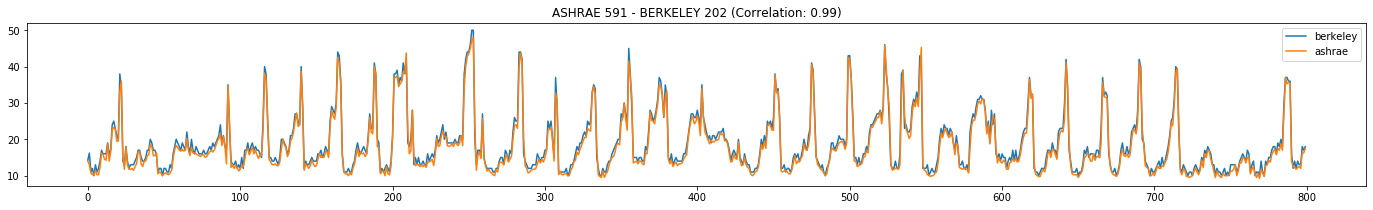

------------------------------------
19 . berkeley  204  is highly correlated to ashrae  565  with score  0.9831395404744033
mae:  0.7707236988953422  whereas mean:  10.504068602664844  mae / mean:  7.337382570976472 %


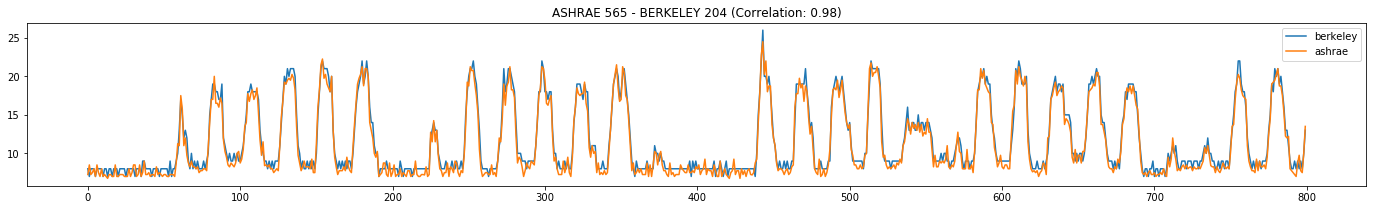

------------------------------------
20 . berkeley  206  is highly correlated to ashrae  624  with score  0.9984719596674526
mae:  0.7516329760928963  whereas mean:  94.31868263888887  mae / mean:  0.7969078395323005 %


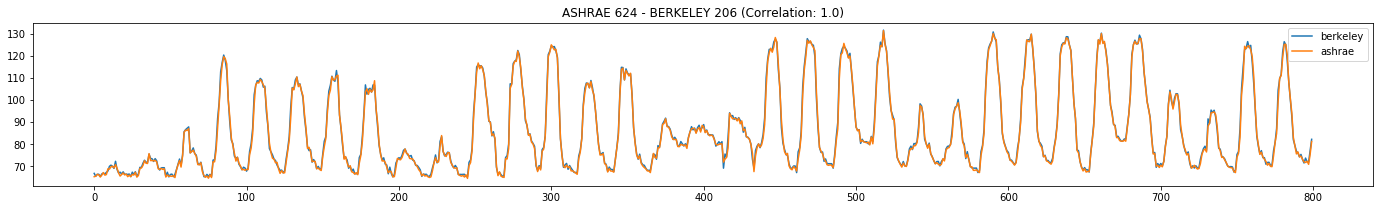

------------------------------------
21 . berkeley  207  is highly correlated to ashrae  634  with score  0.9995268459227435
mae:  0.003449282784608379  whereas mean:  0.2981592782331512  mae / mean:  1.1568591140441211 %


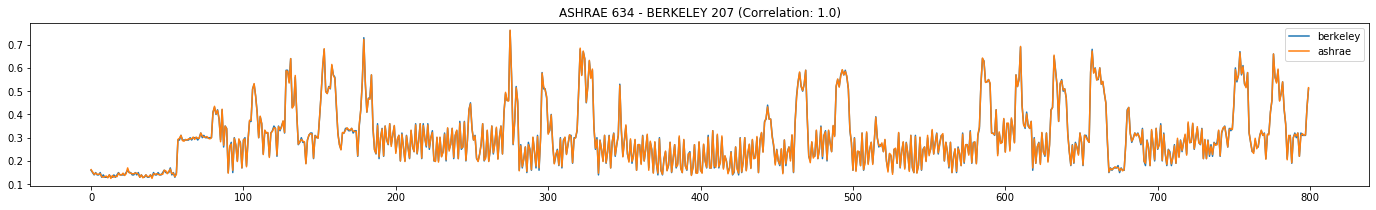

------------------------------------
22 . berkeley  209  is highly correlated to ashrae  573  with score  0.9992863305021483
mae:  0.10763331887522772  whereas mean:  13.595561714480874  mae / mean:  0.7916798226923243 %


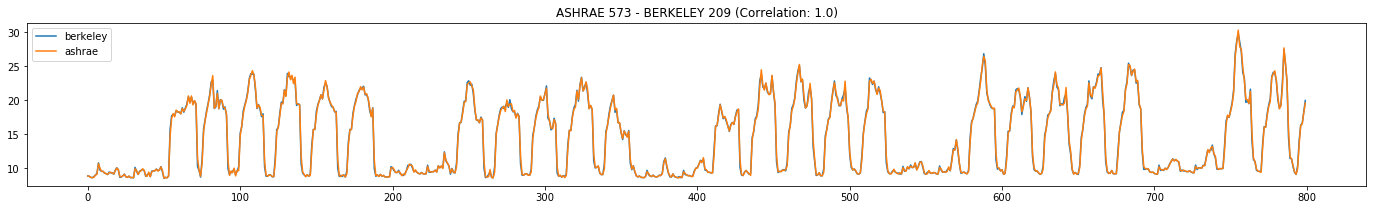

------------------------------------
23 . berkeley  210  is highly correlated to ashrae  568  with score  0.9995867524921254
mae:  0.023693848347984242  whereas mean:  5.7075728099424055  mae / mean:  0.415130023513854 %


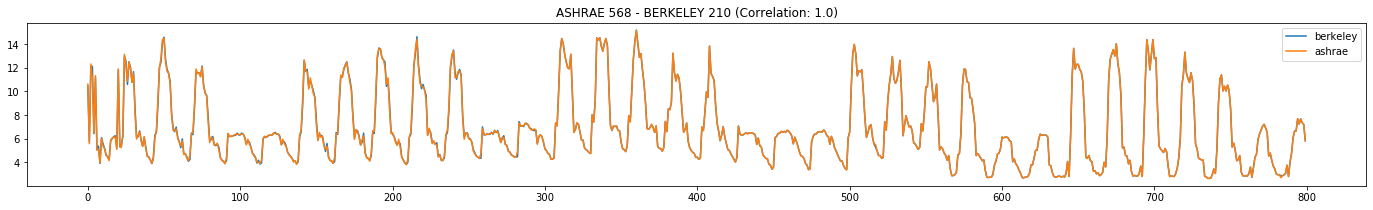

------------------------------------
24 . berkeley  211  is highly correlated to ashrae  635  with score  0.9999602772772284
mae:  0.004136180142340452  whereas mean:  3.4855537510208845  mae / mean:  0.11866637090674631 %


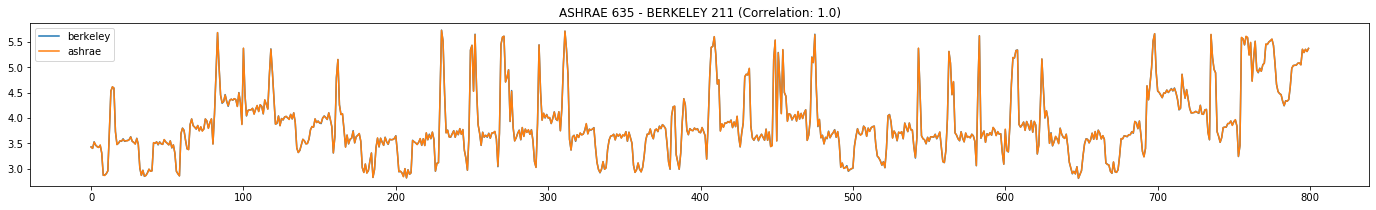

------------------------------------
25 . berkeley  214  is highly correlated to ashrae  599  with score  0.9987077891172477
mae:  0.8948502468123862  whereas mean:  93.24999520719489  mae / mean:  0.9596249788797226 %


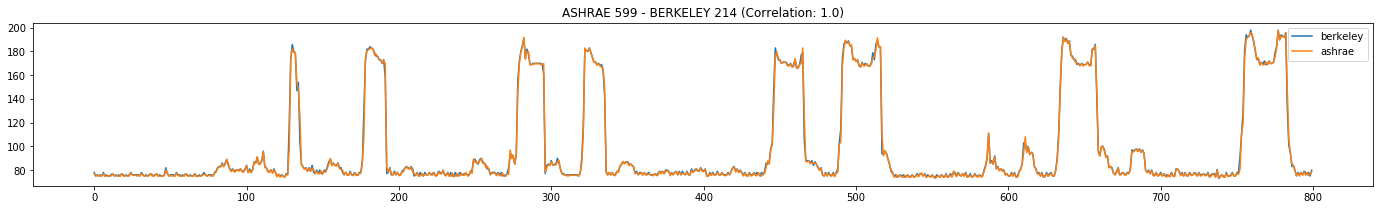

------------------------------------
26 . berkeley  216  is highly correlated to ashrae  592  with score  0.991566762438032
mae:  0.4029987448747154  whereas mean:  393.11547198177675  mae / mean:  0.10251408901387549 %


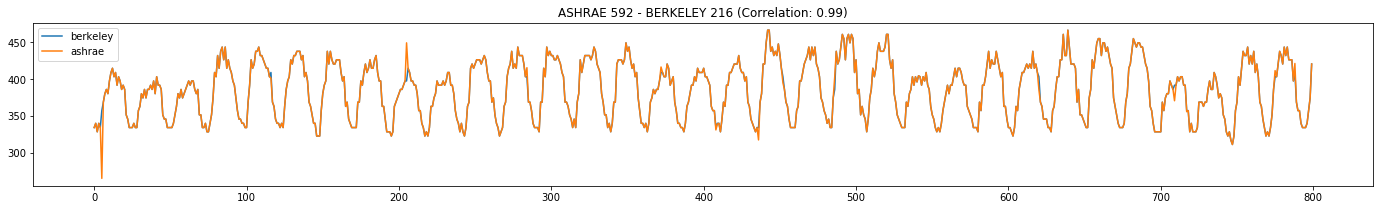

------------------------------------
27 . berkeley  217  is highly correlated to ashrae  644  with score  0.9990385339891754
mae:  1.6220656911966989  whereas mean:  259.9421856946355  mae / mean:  0.6240101762867396 %


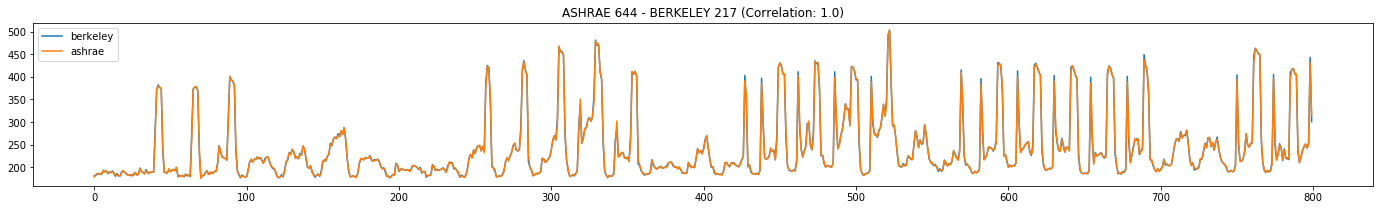

------------------------------------
28 . berkeley  218  is highly correlated to ashrae  620  with score  0.9999996456299259
mae:  0.0011950364298725497  whereas mean:  1299.2501992258651  mae / mean:  9.197892989237875e-05 %


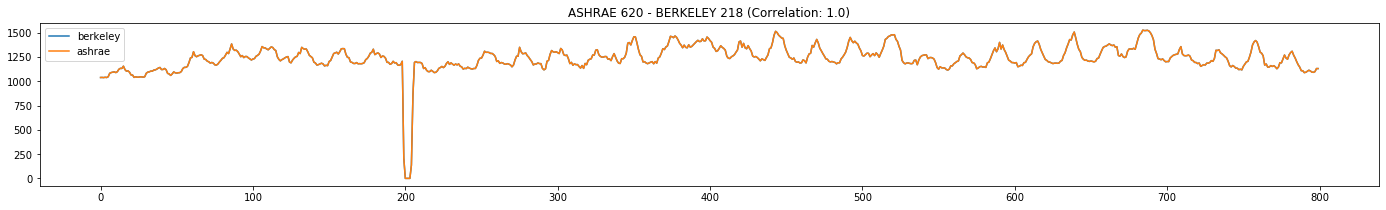

------------------------------------
29 . berkeley  219  is highly correlated to ashrae  631  with score  0.9999917106045634
mae:  0.011419239708561015  whereas mean:  12.591891416211293  mae / mean:  0.09068724730154074 %


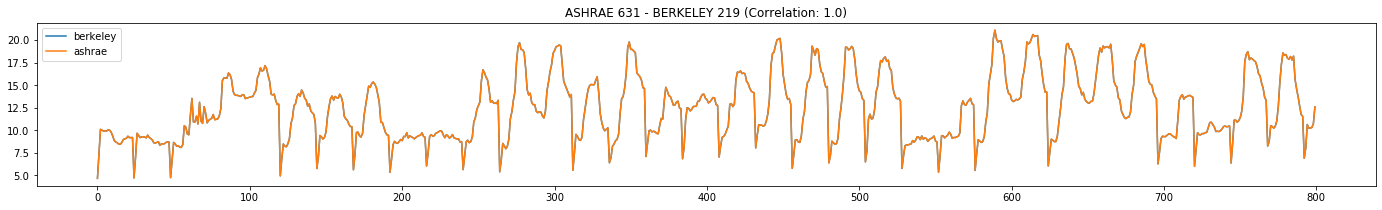

------------------------------------
30 . berkeley  220  is highly correlated to ashrae  638  with score  0.9999848278865213
mae:  0.005028820355191253  whereas mean:  3.6427149817850637  mae / mean:  0.13805143636922554 %


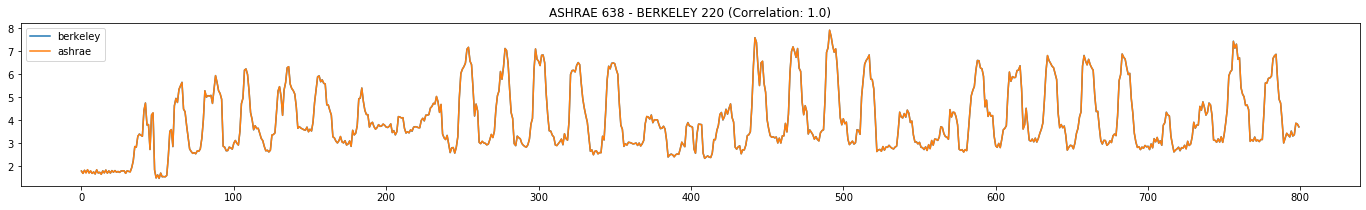

------------------------------------
31 . berkeley  221  is highly correlated to ashrae  595  with score  0.9981429154982777
mae:  2.639596798724953  whereas mean:  232.87338148907105  mae / mean:  1.1334901317816917 %


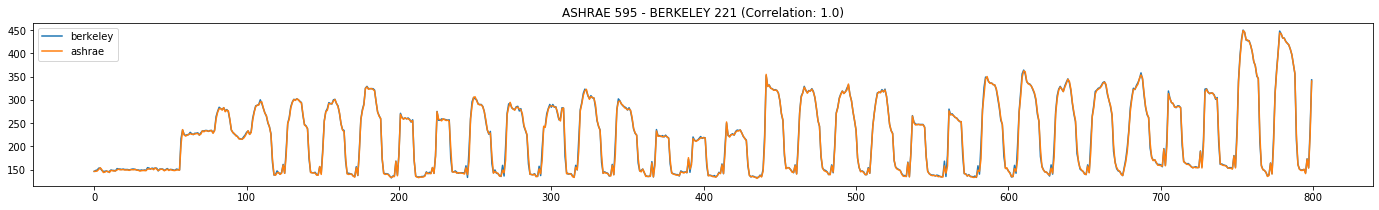

------------------------------------
32 . berkeley  222  is highly correlated to ashrae  611  with score  0.9997416201796103
mae:  0.7441043647516813  whereas mean:  518.3444541701074  mae / mean:  0.1435540322203361 %


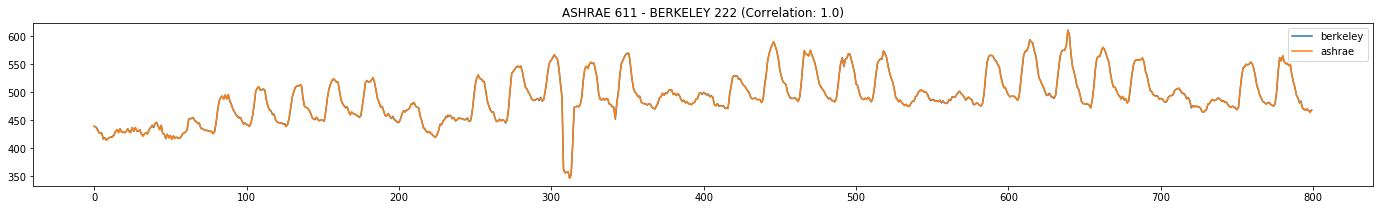

------------------------------------
33 . berkeley  224  is highly correlated to ashrae  569  with score  0.9925818773025635
mae:  5.315261987704917  whereas mean:  327.84731090619306  mae / mean:  1.6212614259403741 %


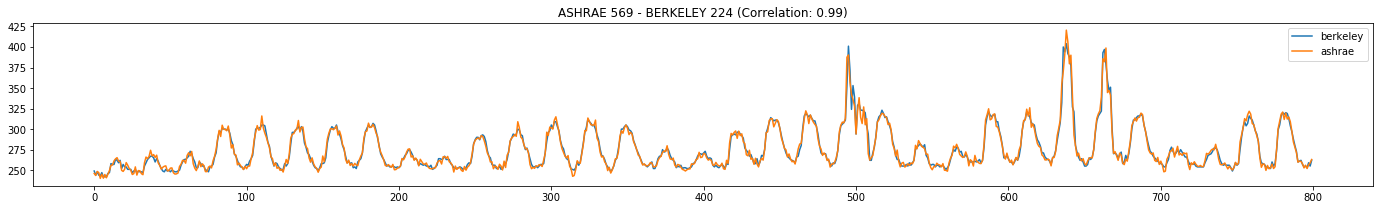

------------------------------------
34 . berkeley  226  is highly correlated to ashrae  645  with score  0.9999068849774524
mae:  0.11407054352780405  whereas mean:  1538.971959206928  mae / mean:  0.007412126182376159 %


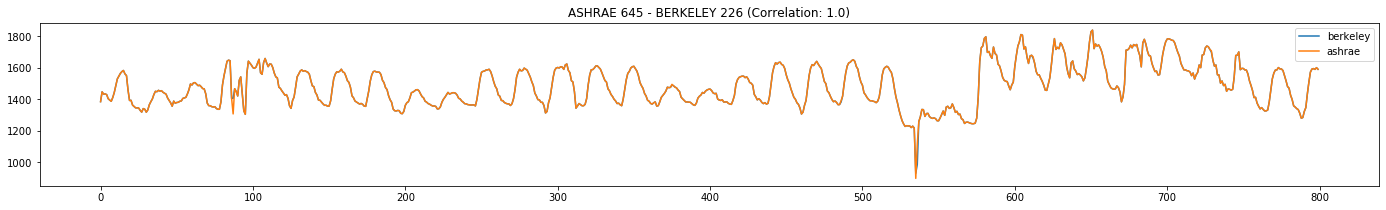

------------------------------------
35 . berkeley  228  is highly correlated to ashrae  607  with score  0.9908088051362968
mae:  0.8983653328350334  whereas mean:  22.057948452339076  mae / mean:  4.072751075541518 %


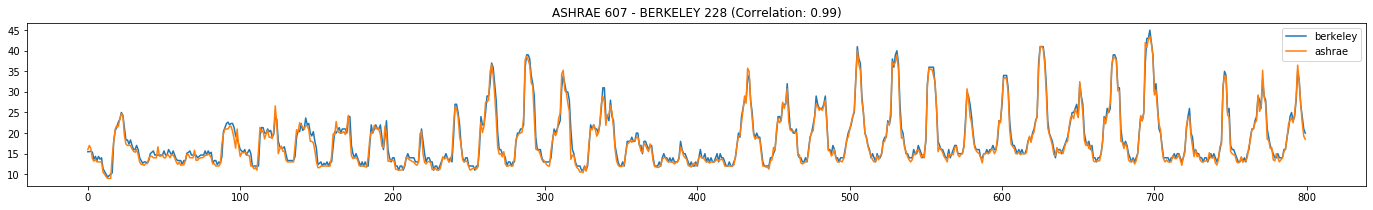

------------------------------------
36 . berkeley  229  is highly correlated to ashrae  606  with score  0.9999544106750091
mae:  0.02972977031196448  whereas mean:  52.665521723231635  mae / mean:  0.05645015816647685 %


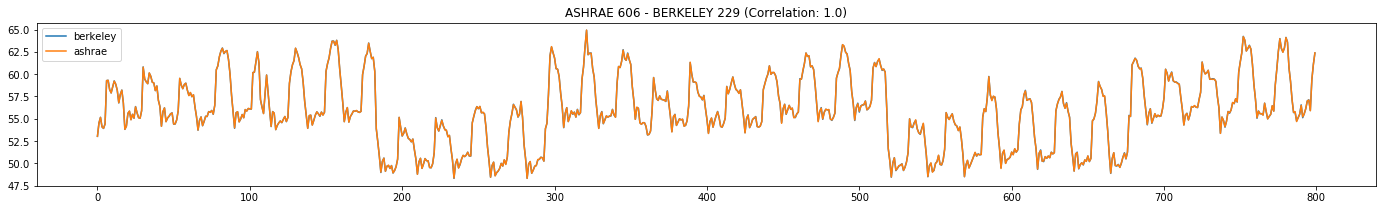

------------------------------------
37 . berkeley  230  is highly correlated to ashrae  613  with score  0.9648996396442601
mae:  0.06473516367482622  whereas mean:  0.8587493653671804  mae / mean:  7.538307017804553 %


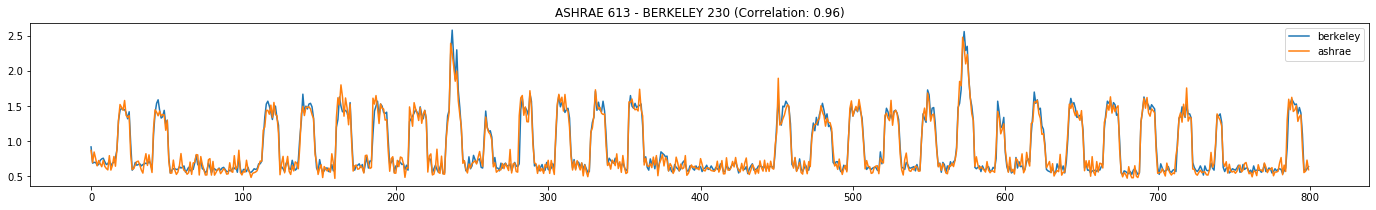

------------------------------------
38 . berkeley  231  is highly correlated to ashrae  626  with score  0.9983152762730725
mae:  1.004463451651472  whereas mean:  123.92712143177403  mae / mean:  0.8105275423543686 %


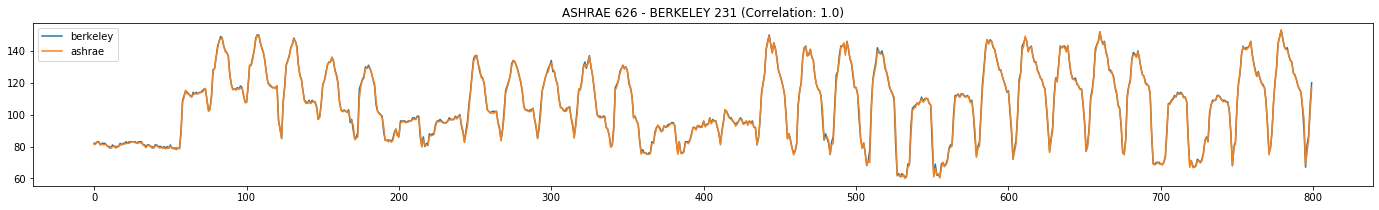

------------------------------------
39 . berkeley  232  is highly correlated to ashrae  596  with score  0.9884836992535057
mae:  0.5670274601640839  whereas mean:  8.96077484047402  mae / mean:  6.3278842539702564 %


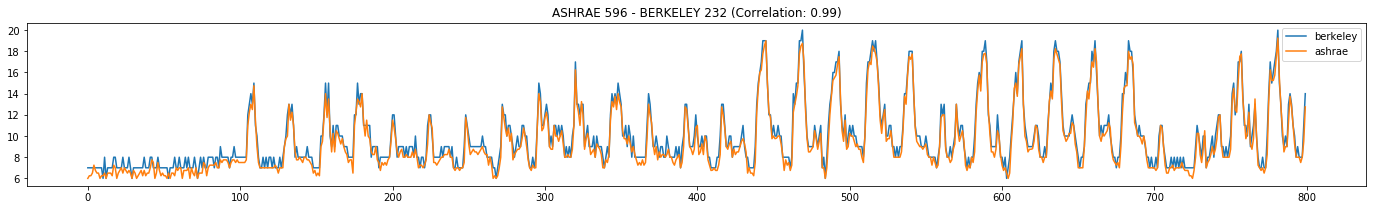

------------------------------------
40 . berkeley  233  is highly correlated to ashrae  632  with score  0.9964978744853211
mae:  0.6657379658158613  whereas mean:  58.575554819963536  mae / mean:  1.136545727756328 %


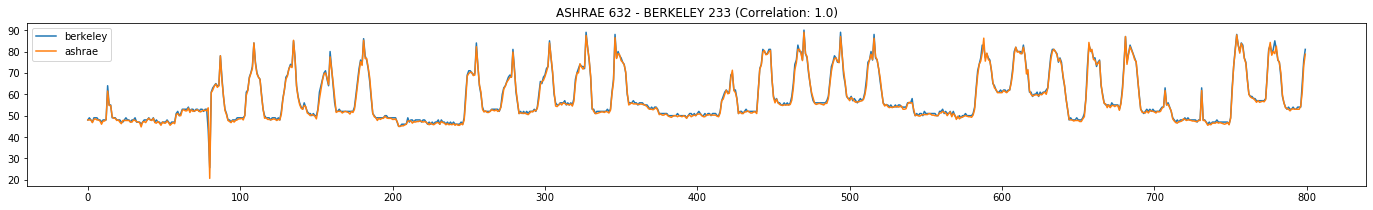

------------------------------------
41 . berkeley  234  is highly correlated to ashrae  566  with score  0.973306296355871
mae:  0.03652076425507246  whereas mean:  0.5342908753623189  mae / mean:  6.8353711319338215 %


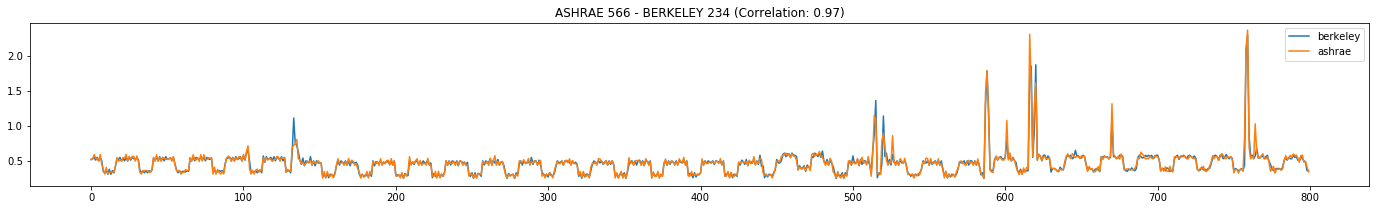

------------------------------------
42 . berkeley  235  is highly correlated to ashrae  610  with score  0.994549796660023
mae:  1.0720909812158472  whereas mean:  44.040867429417126  mae / mean:  2.434309412579243 %


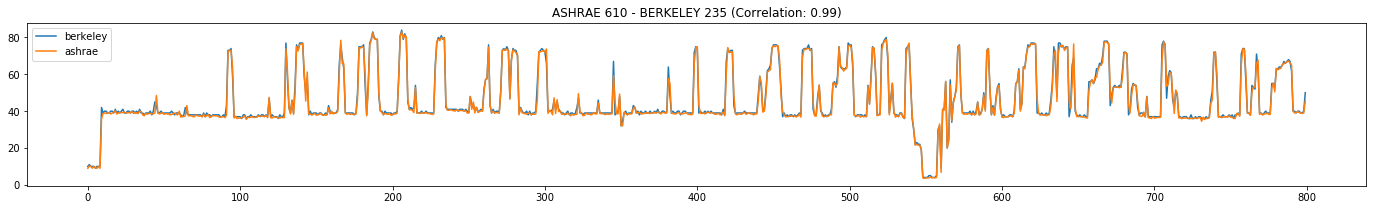

------------------------------------
43 . berkeley  237  is highly correlated to ashrae  628  with score  0.9946174708694516
mae:  0.5587119454121129  whereas mean:  21.386778426684888  mae / mean:  2.6124175145284725 %


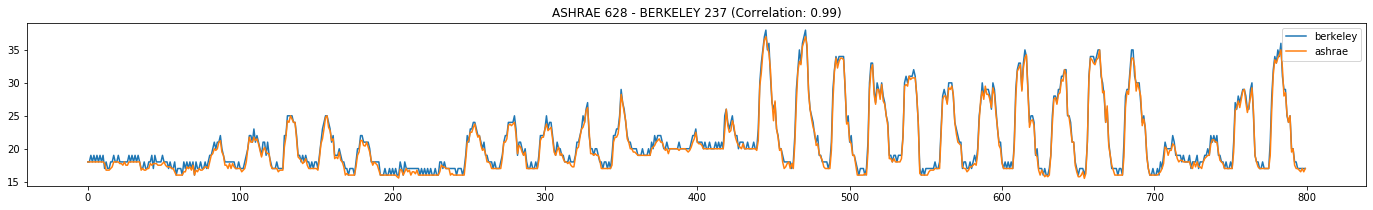

------------------------------------
44 . berkeley  239  is highly correlated to ashrae  575  with score  0.9972960832078113
mae:  0.6421052630558722  whereas mean:  34.68080145952109  mae / mean:  1.851471811588114 %


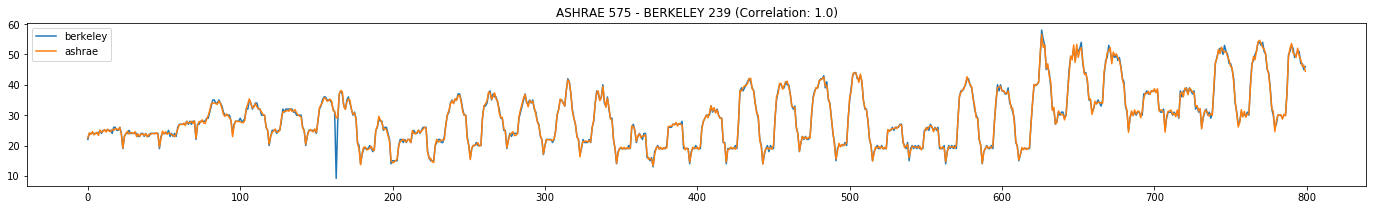

------------------------------------
45 . berkeley  241  is highly correlated to ashrae  579  with score  0.985227972300658
mae:  0.07453070041208791  whereas mean:  1.2561800022893772  mae / mean:  5.933122663651416 %


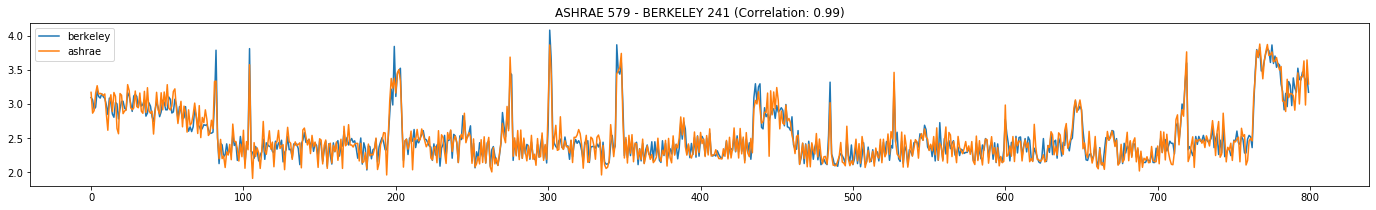

------------------------------------
46 . berkeley  242  is highly correlated to ashrae  588  with score  0.9989273131275336
mae:  0.4314818232923497  whereas mean:  21.875859767759568  mae / mean:  1.9724108120690345 %


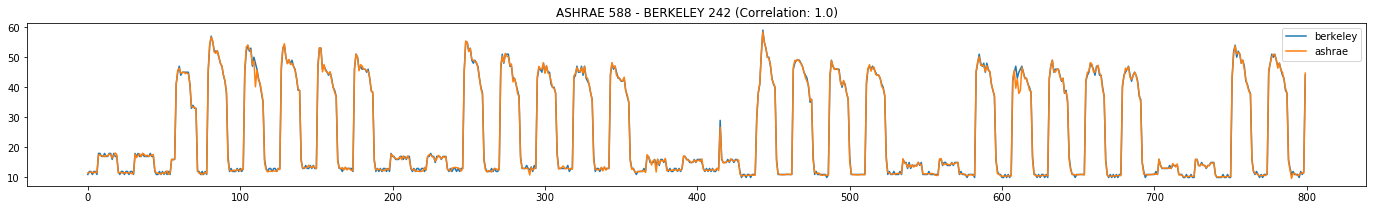

------------------------------------
47 . berkeley  243  is highly correlated to ashrae  570  with score  0.9998128849022776
mae:  0.07791155168488809  whereas mean:  153.01263564435337  mae / mean:  0.050918377659984616 %


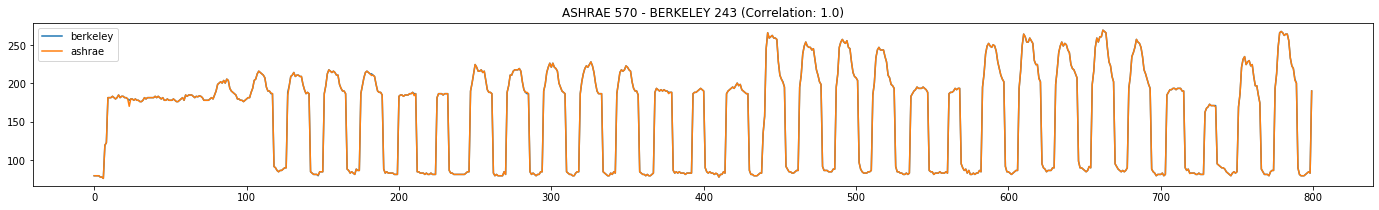

------------------------------------
48 . berkeley  244  is highly correlated to ashrae  571  with score  0.9983816560039754
mae:  1.2665573107923498  whereas mean:  42.048778631602914  mae / mean:  3.0121143871713647 %


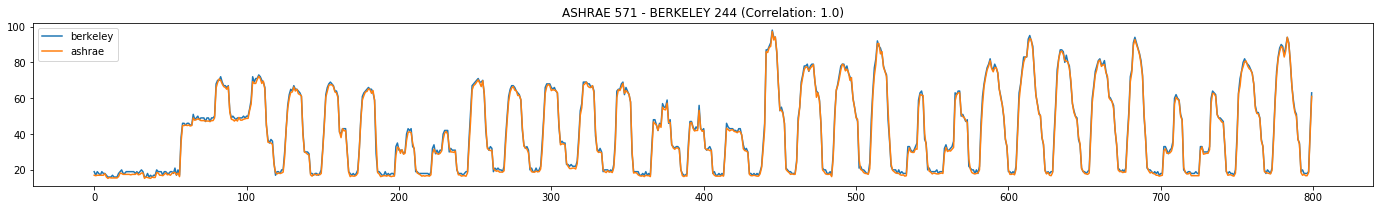

------------------------------------
49 . berkeley  247  is highly correlated to ashrae  574  with score  0.9994357151562947
mae:  0.5400011226092896  whereas mean:  41.67692122040073  mae / mean:  1.2956838144391545 %


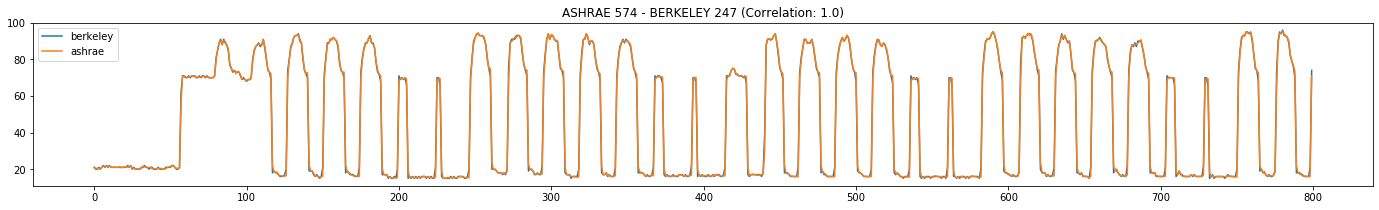

------------------------------------
50 . berkeley  248  is highly correlated to ashrae  583  with score  0.9987456845899458
mae:  10.97137112957256  whereas mean:  522.6251100093797  mae / mean:  2.099281285848599 %


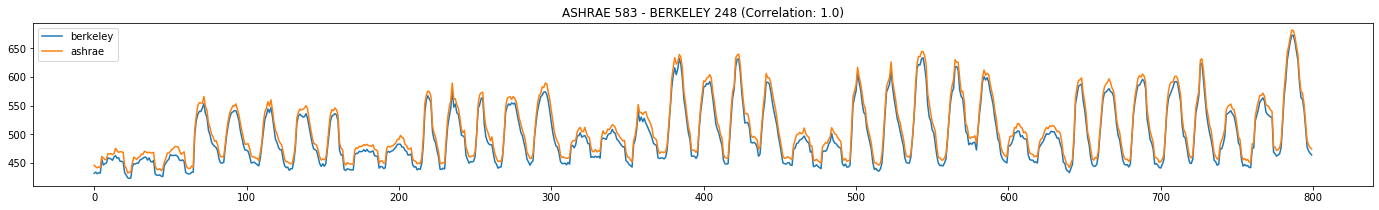

------------------------------------
51 . berkeley  249  is highly correlated to ashrae  584  with score  0.9993840456783023
mae:  1.280482899590164  whereas mean:  142.69552685564665  mae / mean:  0.8973532161842211 %


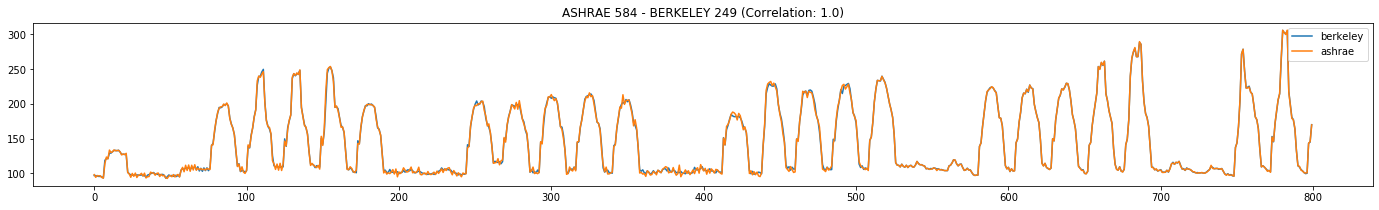

------------------------------------
52 . berkeley  250  is highly correlated to ashrae  586  with score  0.9989384493720113
mae:  1.8922854393214938  whereas mean:  113.95249091530056  mae / mean:  1.6605915536572218 %


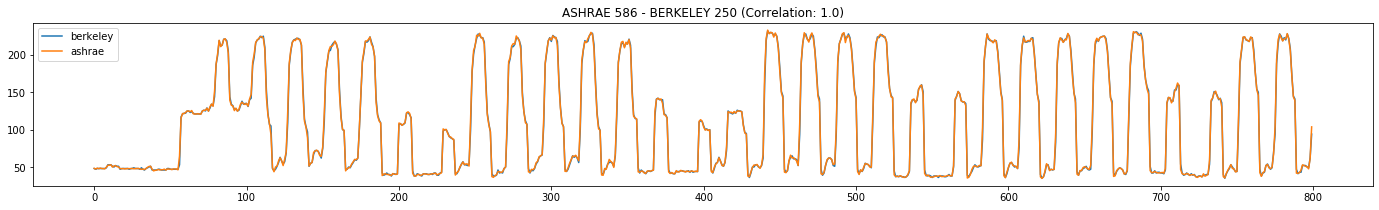

------------------------------------
53 . berkeley  252  is highly correlated to ashrae  585  with score  0.9970514401444694
mae:  2.0001942570875553  whereas mean:  207.4329163156097  mae / mean:  0.9642607801185491 %


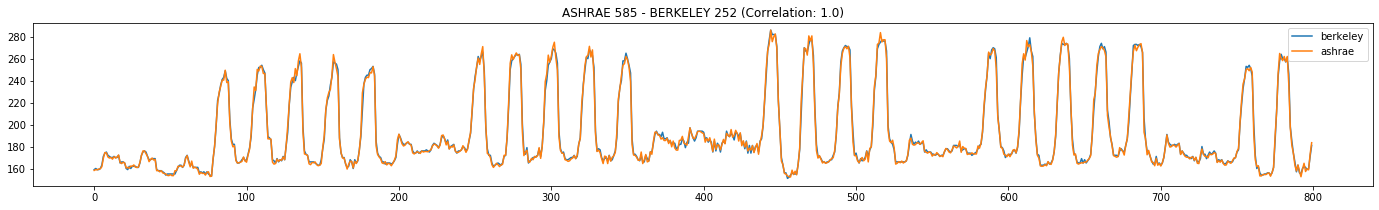

------------------------------------
54 . berkeley  253  is highly correlated to ashrae  587  with score  0.9963095538844041
mae:  0.7447371016408386  whereas mean:  101.42315750911578  mae / mean:  0.7342870404857023 %


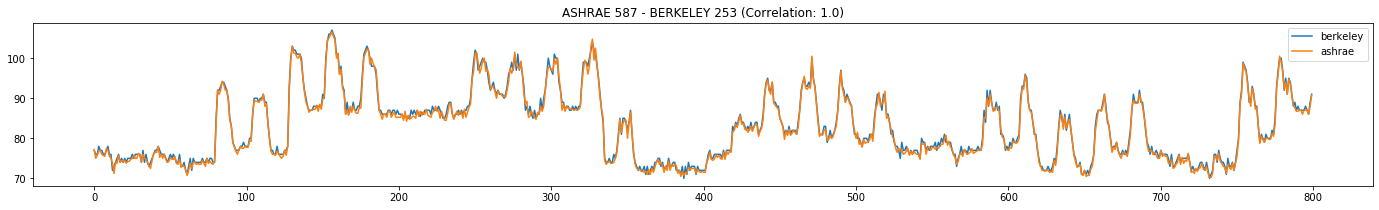

------------------------------------
55 . berkeley  255  is highly correlated to ashrae  589  with score  0.9983729953869811
mae:  1.7916630282331512  whereas mean:  125.69094143897996  mae / mean:  1.4254511961810405 %


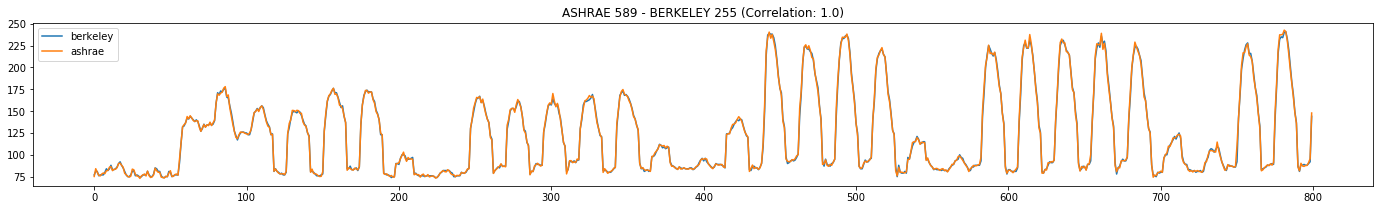

------------------------------------
56 . berkeley  257  is highly correlated to ashrae  594  with score  0.9970406637223347
mae:  2.411564137067394  whereas mean:  381.49362511384334  mae / mean:  0.6321374666084519 %


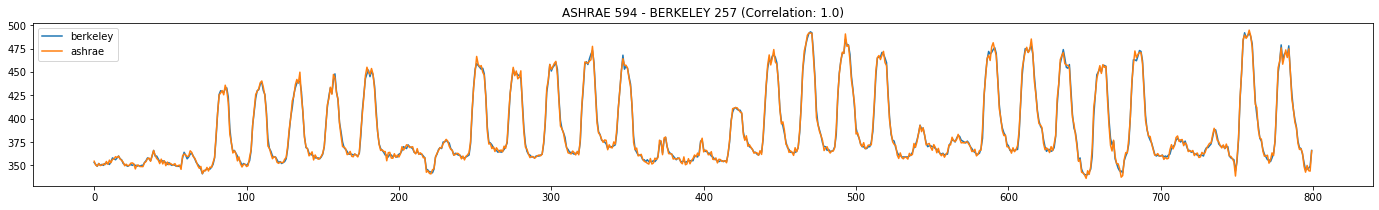

------------------------------------
57 . berkeley  258  is highly correlated to ashrae  600  with score  0.9955048353099785
mae:  1.4905883449965809  whereas mean:  69.06757197401413  mae / mean:  2.1581594696240334 %


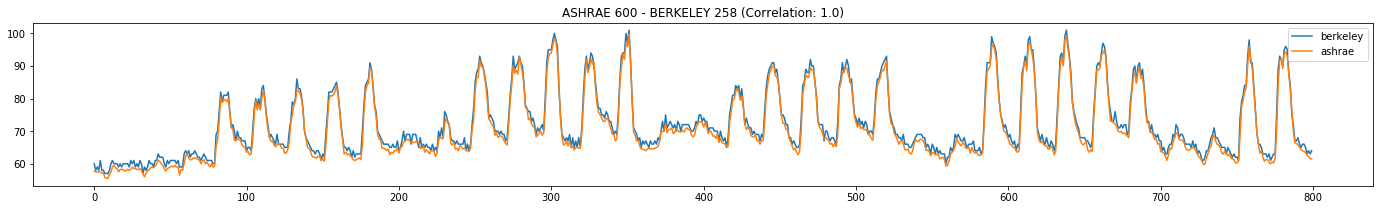

------------------------------------
58 . berkeley  259  is highly correlated to ashrae  597  with score  0.9979133346045969
mae:  2.5199792543260475  whereas mean:  181.6443218920765  mae / mean:  1.3873151817117007 %


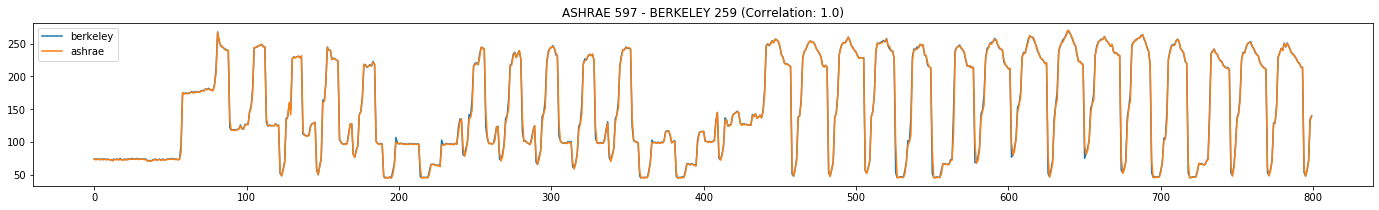

------------------------------------
59 . berkeley  260  is highly correlated to ashrae  601  with score  0.9977144932236252
mae:  0.6798620220459582  whereas mean:  16.223797748746065  mae / mean:  4.190523282987208 %


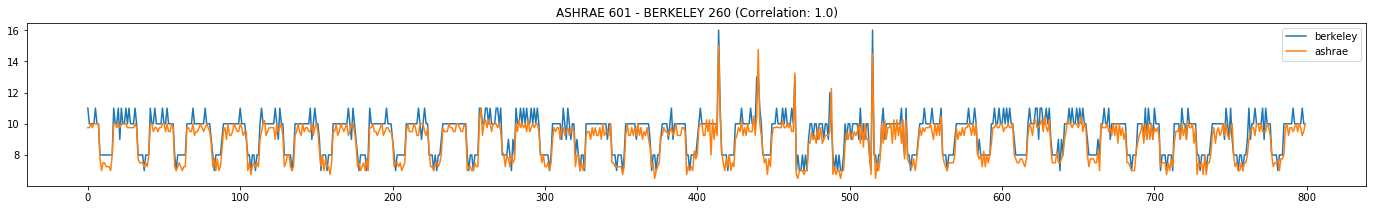

------------------------------------
60 . berkeley  261  is highly correlated to ashrae  598  with score  0.996251754646822
mae:  0.6623656923952641  whereas mean:  50.42280785519126  mae / mean:  1.3136231807984697 %


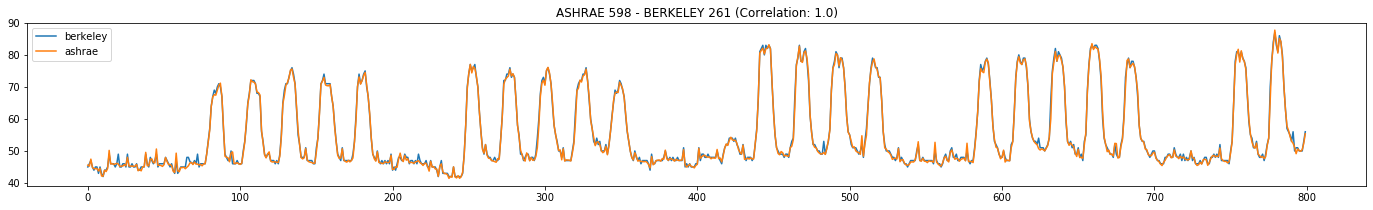

------------------------------------
61 . berkeley  261  is highly correlated to ashrae  630  with score  0.9201164261531662
mae:  3.7033355440674103  whereas mean:  50.453671020268736  mae / mean:  7.340071533307597 %


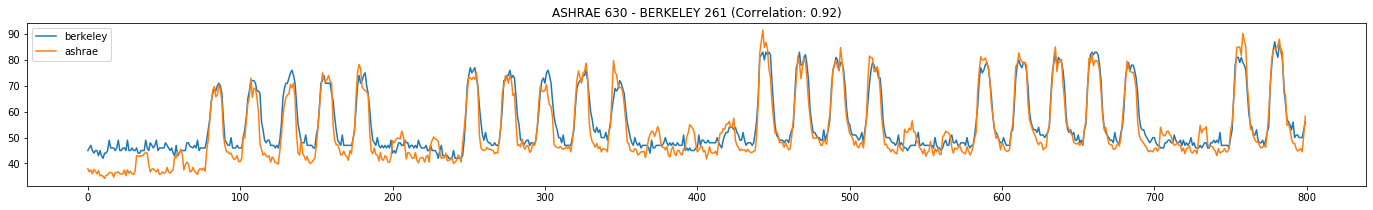

------------------------------------
62 . berkeley  262  is highly correlated to ashrae  580  with score  0.9991235321272657
mae:  1.4224518025956283  whereas mean:  101.6932476320583  mae / mean:  1.3987672099353894 %


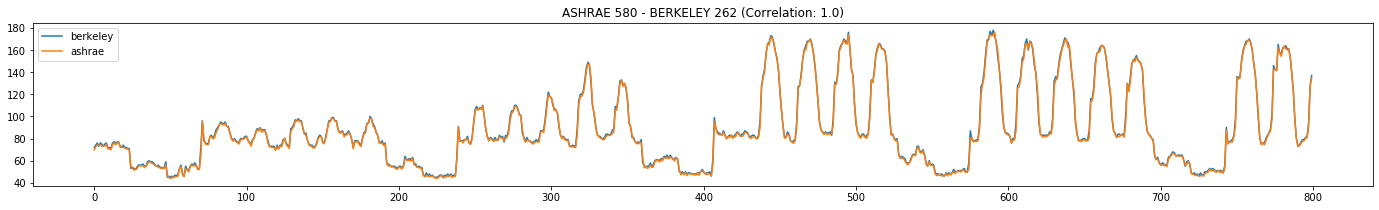

------------------------------------
63 . berkeley  263  is highly correlated to ashrae  602  with score  0.9996735164246774
mae:  2.6104609224575537  whereas mean:  528.6355123402766  mae / mean:  0.4938111158860682 %


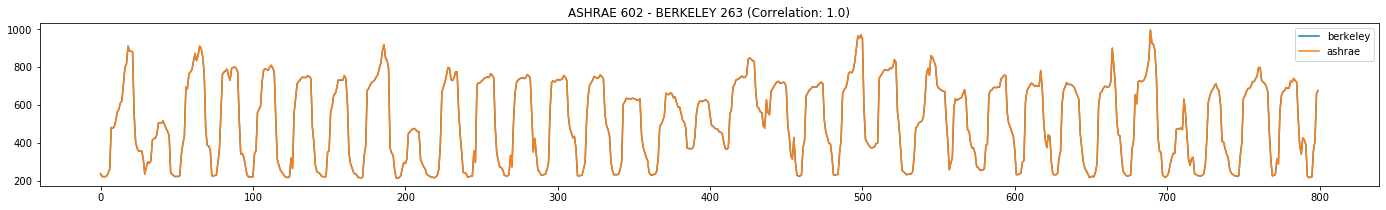

------------------------------------
64 . berkeley  264  is highly correlated to ashrae  614  with score  0.997585549632103
mae:  2.3549758731785064  whereas mean:  180.36780020491804  mae / mean:  1.3056520457104814 %


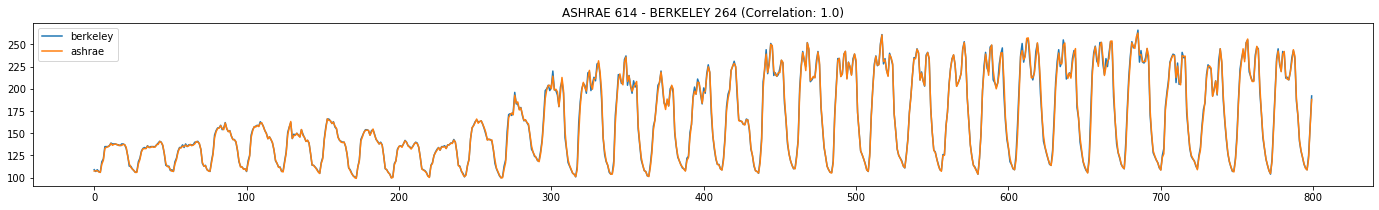

------------------------------------
65 . berkeley  266  is highly correlated to ashrae  603  with score  0.9999844072192501
mae:  0.006772398679417117  whereas mean:  38.08681119080146  mae / mean:  0.017781479907807964 %


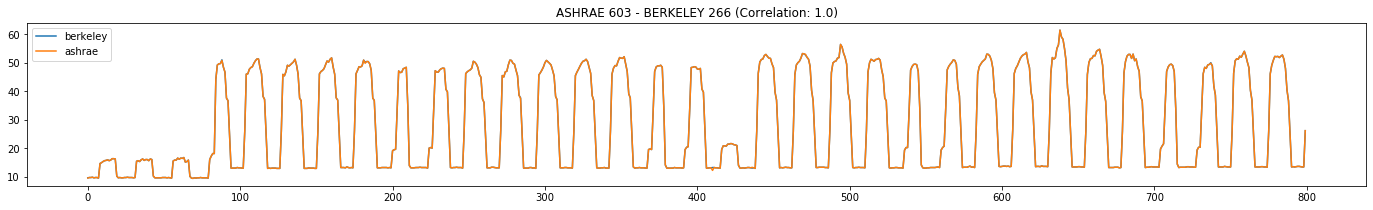

------------------------------------
66 . berkeley  267  is highly correlated to ashrae  605  with score  0.996103443255417
mae:  0.6557385862932603  whereas mean:  24.157678756830602  mae / mean:  2.7144105726956473 %


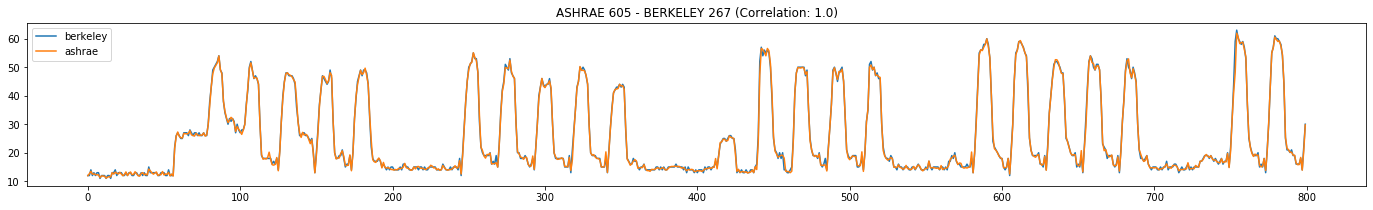

------------------------------------
67 . berkeley  268  is highly correlated to ashrae  608  with score  0.9999995103383663
mae:  0.00014243192167577925  whereas mean:  68.39561542577414  mae / mean:  0.00020824715267070372 %


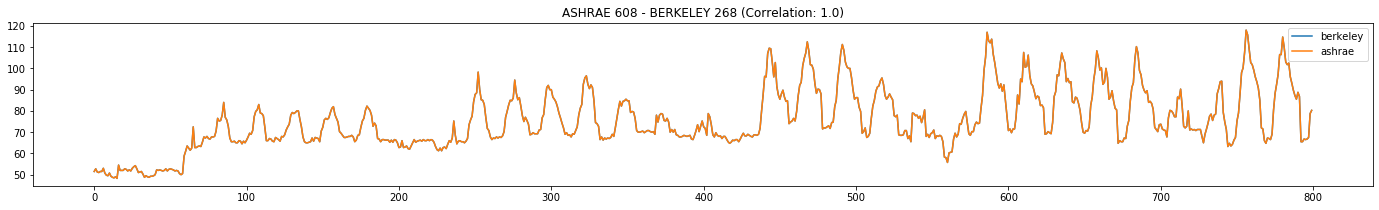

------------------------------------
68 . berkeley  269  is highly correlated to ashrae  609  with score  0.9926606552283039
mae:  1.9957376124331097  whereas mean:  489.9597190026186  mae / mean:  0.4073268750532619 %


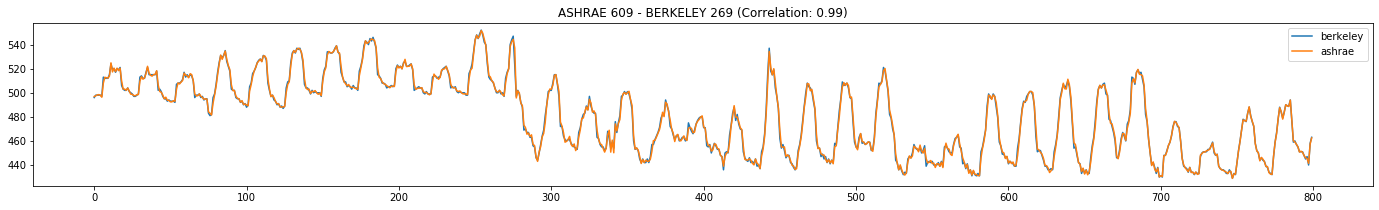

------------------------------------
69 . berkeley  270  is highly correlated to ashrae  612  with score  0.9709817498800287
mae:  1.772630526879271  whereas mean:  88.20663249430525  mae / mean:  2.00963405670624 %


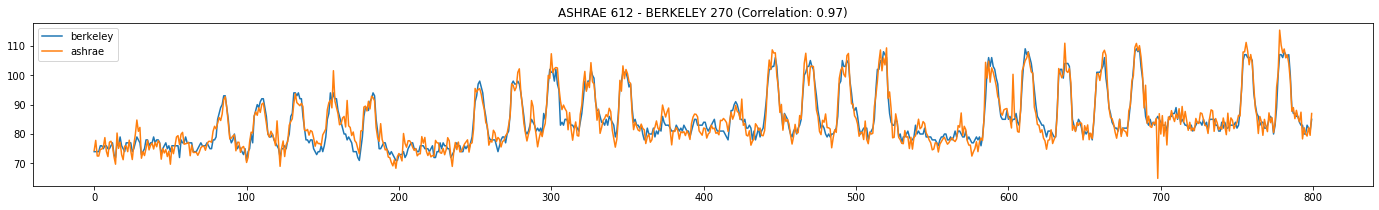

------------------------------------
70 . berkeley  272  is highly correlated to ashrae  615  with score  0.9999999999628832
mae:  0.0002804545454531296  whereas mean:  814.1556782866257  mae / mean:  3.4447287285810074e-05 %


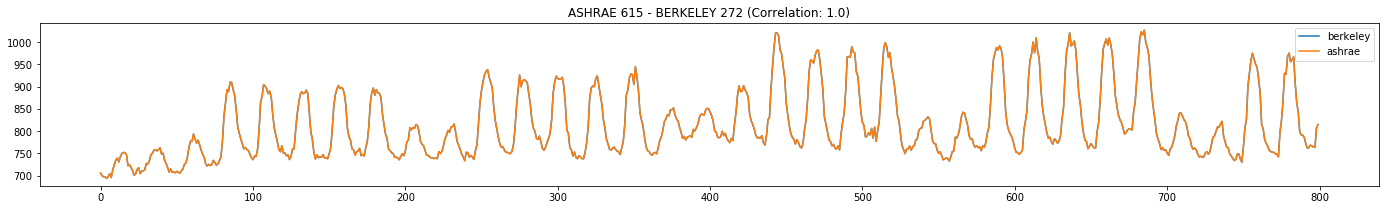

------------------------------------
71 . berkeley  273  is highly correlated to ashrae  616  with score  0.9933895997596842
mae:  2.6729918002049184  whereas mean:  67.58576741803279  mae / mean:  3.954962564339735 %


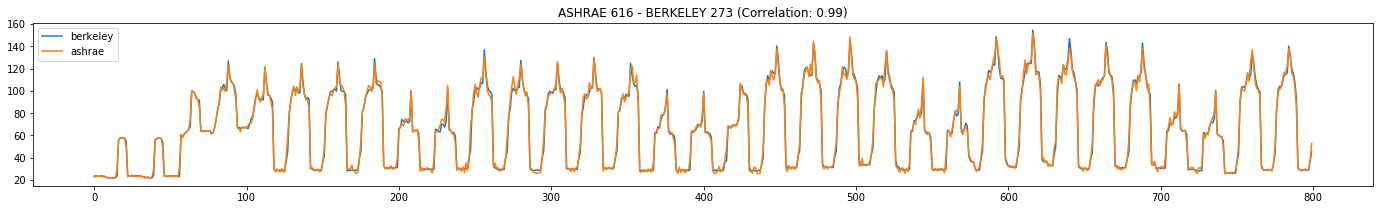

------------------------------------
72 . berkeley  274  is highly correlated to ashrae  617  with score  0.9979481473370923
mae:  3.6125372848360664  whereas mean:  623.5063307149362  mae / mean:  0.5793906343651384 %


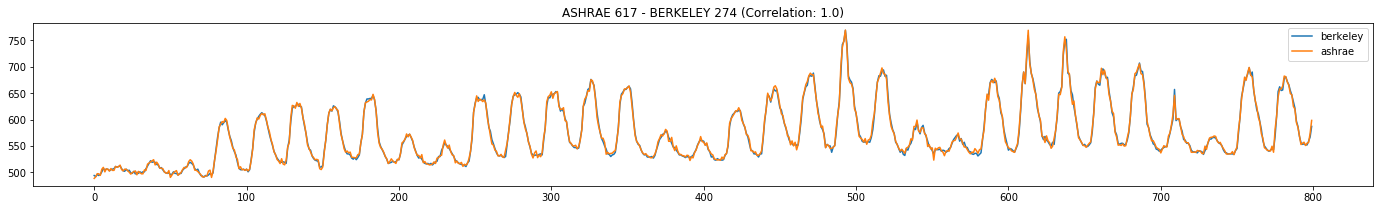

------------------------------------
73 . berkeley  276  is highly correlated to ashrae  567  with score  0.9969274343184052
mae:  0.044573253029428286  whereas mean:  161.98486863819966  mae / mean:  0.02751692389798742 %


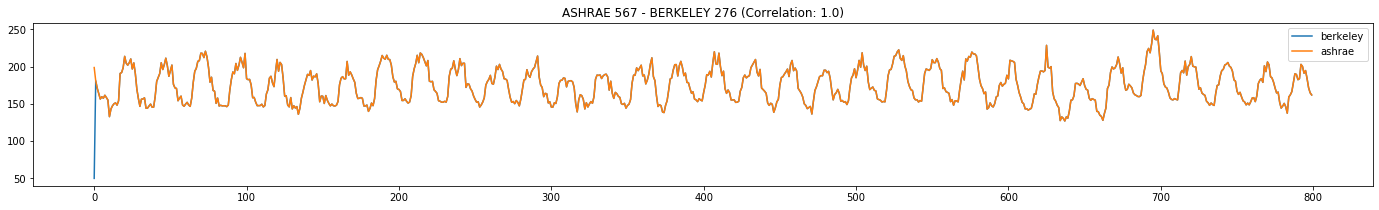

------------------------------------
74 . berkeley  277  is highly correlated to ashrae  618  with score  0.99997291253363
mae:  0.026097711748633855  whereas mean:  119.24343932149363  mae / mean:  0.021886077671972804 %


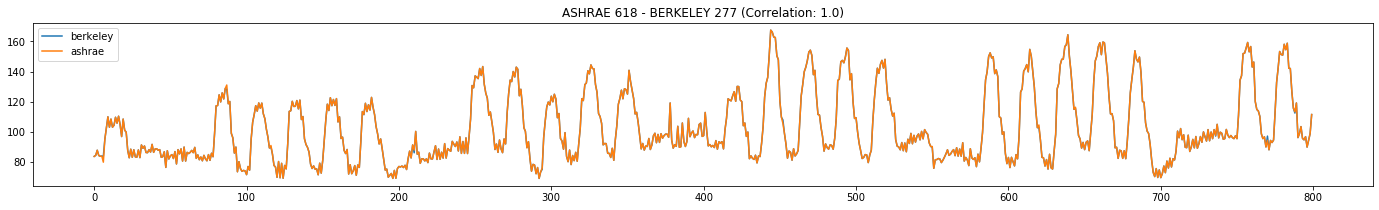

------------------------------------
75 . berkeley  279  is highly correlated to ashrae  619  with score  0.9859703819848369
mae:  2.590636286626382  whereas mean:  184.21533587960326  mae / mean:  1.4063086953409416 %


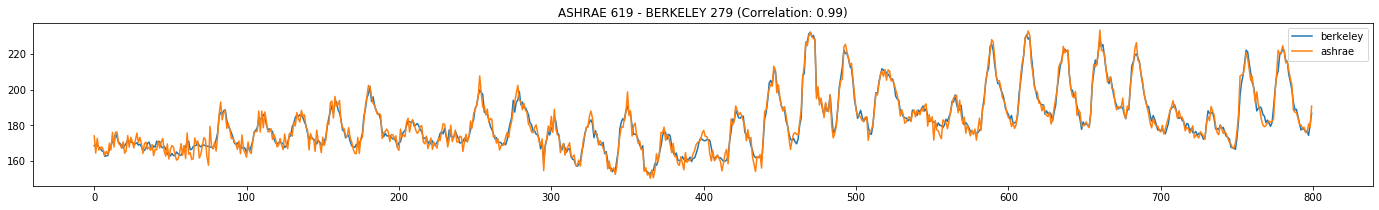

------------------------------------
76 . berkeley  281  is highly correlated to ashrae  604  with score  0.9995465677154517
mae:  0.0044287827601215525  whereas mean:  1.5311721068249258  mae / mean:  0.2892413426538431 %


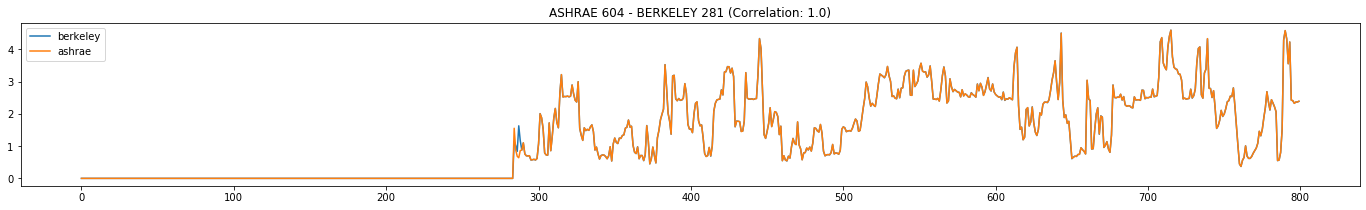

------------------------------------
77 . berkeley  282  is highly correlated to ashrae  622  with score  0.9943945015453767
mae:  3.355926618852459  whereas mean:  216.46814549180328  mae / mean:  1.5503096823913676 %


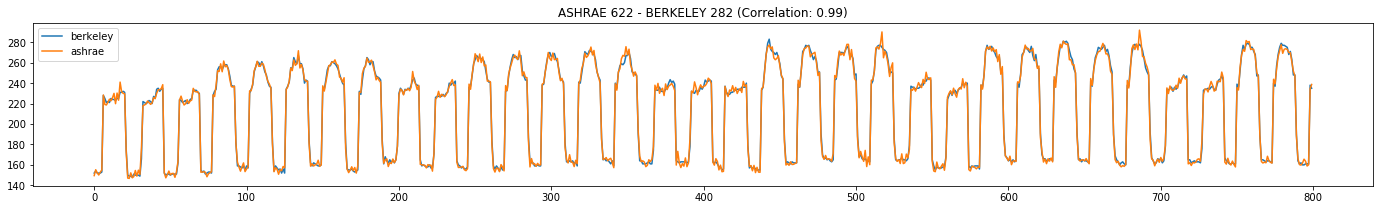

------------------------------------
78 . berkeley  286  is highly correlated to ashrae  577  with score  0.9999999797238898
mae:  5.271053117783384e-05  whereas mean:  56.93109272517321  mae / mean:  9.258654393353464e-05 %


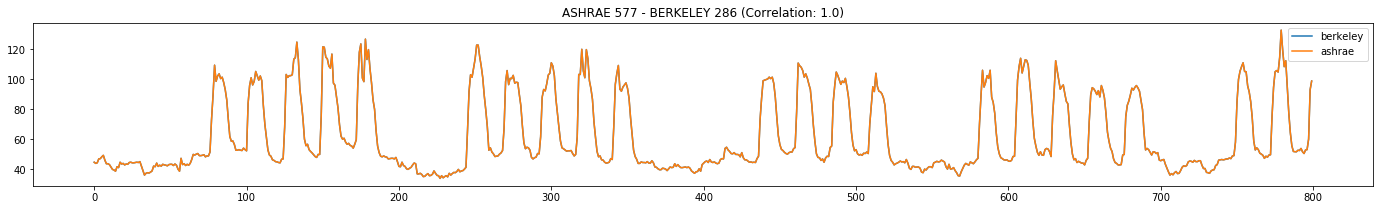

------------------------------------
79 . berkeley  287  is highly correlated to ashrae  627  with score  0.9906564611748195
mae:  1.4488897042814848  whereas mean:  112.15728052835347  mae / mean:  1.291837406770222 %


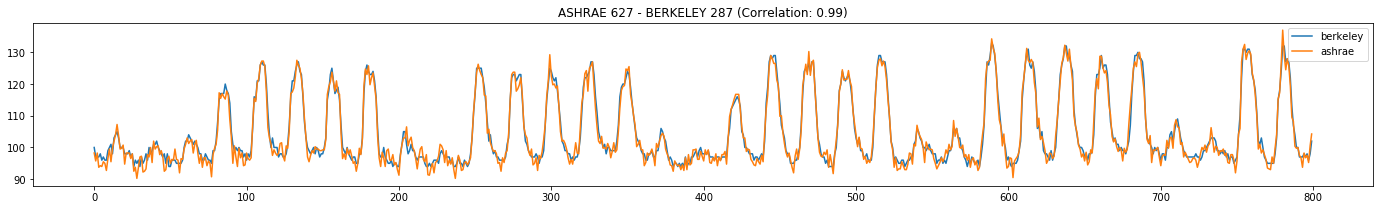

------------------------------------
80 . berkeley  288  is highly correlated to ashrae  598  with score  0.9182406018965042
mae:  3.6893112929553733  whereas mean:  50.42280785519126  mae / mean:  7.3167509900493215 %


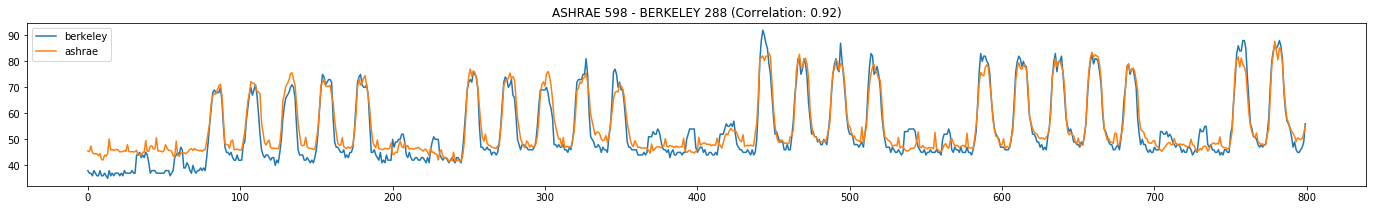

------------------------------------
81 . berkeley  288  is highly correlated to ashrae  630  with score  0.9942845866234312
mae:  1.0004691404008197  whereas mean:  50.453671020268736  mae / mean:  1.9829461765010155 %


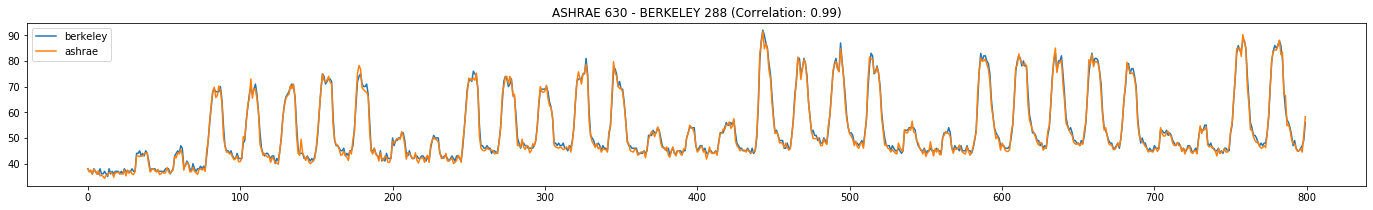

------------------------------------
82 . berkeley  289  is highly correlated to ashrae  640  with score  0.9954606372412084
mae:  5.075197807377049  whereas mean:  258.64744478597447  mae / mean:  1.9622068223317157 %


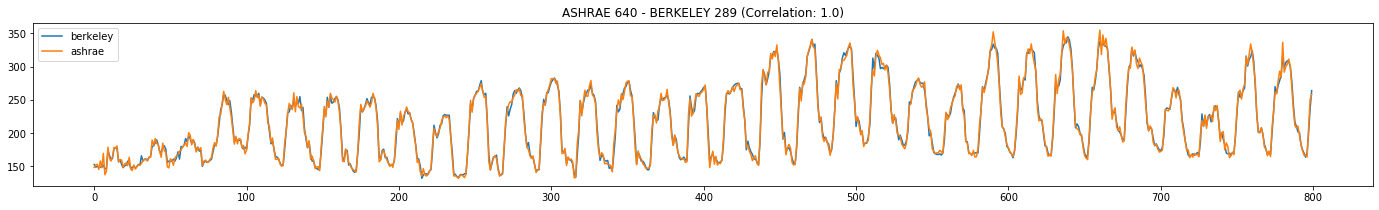

------------------------------------
83 . berkeley  291  is highly correlated to ashrae  633  with score  0.9889737155290901
mae:  0.0016529650381509854  whereas mean:  27.614018801958775  mae / mean:  0.0059859633253879505 %


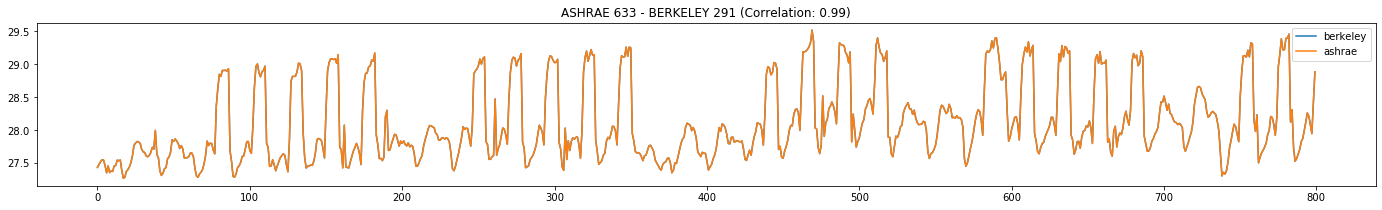

------------------------------------


In [35]:
lookup_list = [] #this will store ashrae id and berkeley id matching

leak_validation = leak[leak.timestamp.dt.year == 2016] #We can confirm Berkeley data with ASHRAE 2016 data

matched = 0; index = 0

for i in berkeley_buildings:
    for j in ashrae_buildings:
        
        df1 = leak_validation[(leak_validation.berkeley_id == i)]
        df2 = train_df[train_df.building_id == j]
        
        tmp = df1.merge(df2, on = ['timestamp'], how='left')
        tmp = tmp.dropna()
        correlation = tmp[['meter_reading_x', 'meter_reading_y']].corr(method ='pearson').values[0,1]
        
        mean = tmp.meter_reading_y.mean()
        mae = abs(tmp.meter_reading_x - tmp.meter_reading_y).sum()/tmp.shape[0]
        mae_over_mean = 100*mae/mean
        
        #print(i," ",j," (",correlation,")")
        
        if correlation >= correlation_threshold and mae_over_mean <= mae_correlation:
            matched = matched + 1
            print(matched,". berkeley ",i," is highly correlated to ashrae ",j," with score ",correlation)
            print("mae: ",mae," whereas mean: ",mean," mae / mean: ",100*mae/mean,"%")
            
            lookup_item = []
            lookup_item.append(i)
            lookup_item.append(j)
            lookup_item.append(mae)
            lookup_list.append(lookup_item)
            
            fig, ax = plt.subplots(figsize=(24, 3))
            plt.title("ASHRAE %s - BERKELEY %s (Correlation: %s)"%(j, i,round(correlation, 2)))
            
            if tmp.meter_reading_x.values[0:800].shape[0] > 0:
                berkeley_graph = tmp.meter_reading_x.values[0:800]
                ashrae_graph = tmp.meter_reading_y.values[0:800]
            else:
                berkeley_graph = tmp.meter_reading_x.values
                ashrae_graph = tmp.meter_reading_y.values
                
            plt.plot(berkeley_graph, label='berkeley')    
            plt.plot(ashrae_graph, label='ashrae')
            plt.legend()
            plt.show()
            
            print("------------------------------------")
            
        index = index + 1

In [36]:
building_lookup = pd.DataFrame(lookup_list, columns=['berkeley_id', 'ashrae_id', 'mae'])

In [37]:
building_lookup.head()

berkeley_id  ashrae_id       mae
0          176        641  4.042443
1          177        643  1.579731
2          178        646  1.529303
3          179        621  0.169537
4          180        649  1.191780

There are some duplicates (e.g. 598 or 630)

In [38]:
building_lookup[(building_lookup.ashrae_id == 630) | (building_lookup.ashrae_id == 598)]

berkeley_id  ashrae_id       mae
59          261        598  0.662366
60          261        630  3.703336
79          288        598  3.689311
80          288        630  1.000469

 We will dismiss buildings having high error

In [39]:
building_lookup_best = building_lookup.groupby("ashrae_id", as_index=False)["mae"].min()

In [40]:
building_lookup = building_lookup.merge(building_lookup_best, on =["ashrae_id", "mae"], how="inner")

In [41]:
building_lookup.head()

berkeley_id  ashrae_id       mae
0          176        641  4.042443
1          177        643  1.579731
2          178        646  1.529303
3          179        621  0.169537
4          180        649  1.191780

In [42]:
print("There are ",building_lookup.shape[0]," buildings in Berkeley data set matched with ASHRAE data set")

There are  81  buildings in Berkeley data set matched with ASHRAE data set


In [47]:
building_data = source.merge(building_lookup, how = 'left', on = 'berkeley_id')

In [49]:
building_data.head(50)

berkeley_id  square_feet  year                                       name  \
0           173       252597  1984               Recreational Sports Facility   
1           174        43599  1998  Silver Space Sciences Laboratory Addition   
2           175        54000  2015                       Maxwell Family Field   
3           176       110565  1994                                  Soda Hall   
4           177       111198  1941                                Sproul Hall   
5           178        59548  1923                              Stephens Hall   
6           179       104000  2015                             Maxwell Garage   
7           180       118376  1996                                   Tan Hall   
8           181        77369  1993                                Tang Center   
9           182       246966  1962                                Tolman Hall   
10          183       152987  1959                            University Hall   
11          184       421939  1930              Valley Life Sciences Building   
12          185        44251  1912                               Wellman Hall   
13          186        40895    -1                                 Moses Hall   
14          187       139735  1917                               Wheeler Hall   
15          188       154869  1968                            Zellerbach Hall   
16          189       121000    -1             Upper Hearst Parking Structure   
17          190           -1    -1                                      MSRI    
18          191        64800  2015                              Eshleman Hall   
19          192        28453    -1                  Genetics & Plant Biology    
20          193        49388  1931                            McLaughlin Hall   
21          194        81600    -1                              Campbell Hall   
22          195        30401    -1                                 South Hall   
23          196        14945    -1                        2251 College Avenue   
24          197         6706    -1                          2232 Piedmont Ave   
25          198         4281    -1                          2234 Piedmont Ave   
26          199        24000  2015                                Jacobs Hall   
27          200        14524    -1                              Pimentel Hall   
28          201       306211    -1                         Underhill Parking    
29          202        71863    -1                            Edwards Stadium   
30          203         8787  1920                            Dwinelle Annex    
31          204        15590  1954                              Alumni House    
32          205        35557    -1                         Men's Faculty Club   
33          206        46225    -1                                 Minor Hall   
34          207         4085    -1                          2222 Piedmont Ave   
35          208        41444  1924                                 Hesse Hall   
36          209        26266  2010                                  Blum Hall   
37          210        14468    -1                          2200 Bancroft Way   
38          211         7271    -1                          2224 Piedmont Ave   
39          212       105833  1970                           Woo Han Fai Hall   
40          214        26004  1954                               Giauque Hall   
41          215       140580    -1             Lower Hearst Parking Structure   
42          216       124175  2012                Energy Biosciences Building   
43          217       275807  2012                California Memorial Stadium   
44          218       210000  2011                         Li Ka-Shing Center   
45          219        23745    -1                            North Gate Hall   
46          220         8000    -1                          2240 Piedmont Ave   
47          221       277388  1971                                 Evans Hall   
48          222       135129  1966 

In [52]:
with open('berkeley_building_info.pkl', 'wb') as to_write:
    pickle.dump(building_data, to_write)

In [28]:
leak = leak.merge(building_lookup, on=['berkeley_id'], how='left')

In [29]:
leak = leak[leak.ashrae_id > 0]

In [30]:
len(leak.ashrae_id.unique())

81

In [31]:
leak.head()

berkeley_id           timestamp  meter_reading  ashrae_id       mae
78960          176 2016-01-01 00:00:00        358.548      641.0  4.046878
78961          176 2016-01-01 01:00:00        355.919      641.0  4.046878
78962          176 2016-01-01 02:00:00        328.179      641.0  4.046878
78963          176 2016-01-01 03:00:00        326.403      641.0  4.046878
78964          176 2016-01-01 04:00:00        325.490      641.0  4.046878

In [32]:
pd.DataFrame(leak.groupby("ashrae_id")["mae"].mean()).sort_values(by=['mae'])

mae
ashrae_id           
577.0       0.000099
608.0       0.000285
576.0       0.000285
615.0       0.001021
633.0       0.001662
620.0       0.003098
637.0       0.003430
634.0       0.003452
636.0       0.003472
635.0       0.004157
604.0       0.004429
582.0       0.004994
638.0       0.005054
603.0       0.006818
631.0       0.011433
568.0       0.023717
618.0       0.026177
606.0       0.029780
566.0       0.036545
567.0       0.046455
613.0       0.064741
579.0       0.074504
570.0       0.078108
573.0       0.107650
645.0       0.118390
621.0       0.169602
652.0       0.388245
592.0       0.404311
588.0       0.431473
574.0       0.539975
628.0       0.558740
596.0       0.567084
642.0       0.598435
623.0       0.622438
575.0       0.642074
605.0       0.655709
598.0       0.662402
632.0       0.665795
639.0       0.675349
601.0       0.679862
611.0       0.743975
587.0       0.744937
624.0       0.751768
565.0       0.770752
654.0       0.825409
599.0       0.894879
607.0       0.898453
630.0       1.000498
626.0       1.004688
610.0       1.072091
591.0       1.141091
649.0       1.191757
571.0       1.266614
584.0       1.280995
580.0       1.423021
627.0       1.449032
600.0       1.490560
646.0       1.529443
643.0       1.579817
644.0       1.638100
612.0       1.772647
589.0       1.791660
586.0       1.892254
609.0       1.997474
585.0       2.000137
655.0       2.179252
614.0       2.355431
594.0       2.411932
597.0       2.521658
619.0       2.591652
602.0       2.610131
595.0       2.639566
616.0       2.672804
622.0       3.356510
617.0       3.612190
641.0       4.046878
640.0       5.077503
650.0       5.297106
569.0       5.318364
653.0       6.502430
583.0      10.971237

In [33]:
site4 = leak.copy()

In [34]:
site4 = site4.drop(columns = ['berkeley_id'])
site4 = site4.rename(columns = {"ashrae_id": "building_id", "meter_reading": "meter_reading_scraped"})
site4['building_id'] = site4['building_id'].astype('int32')

In [35]:
site4 = site4[['building_id', 'timestamp', 'meter_reading_scraped']]

In [36]:
site4.sample(10)

building_id           timestamp  meter_reading_scraped
2885455          622 2017-11-21 15:00:00              268.00000
903425           634 2016-12-22 01:00:00                0.15000
654779           636 2018-08-20 12:00:00                0.18000
2628666          615 2018-08-15 19:00:00              708.99475
985674           568 2017-05-08 03:00:00                2.15000
2175783          589 2017-12-31 23:00:00               83.00000
2118512          587 2017-06-22 01:00:00              101.00000
3125088          633 2018-03-16 09:00:00               28.82300
2229996          594 2018-03-07 12:00:00              458.00000
1705479          628 2018-05-25 00:00:00               19.00000

In [37]:
site4.shape

(2131920, 3)

In [38]:
print("There are ",site4[site4.timestamp.dt.year > 2016].shape," instances in test set")

There are  (1420416, 3)  instances in test set


In [39]:
site4.to_csv("site4.csv", index=False)